# Load Data

In [1]:
# Setup the dependencies
using Pkg; Pkg.add("Suppressor"); using Suppressor: @suppress;
@suppress Pkg.add(url="https://github.com/JuDO-dev/AirBorne.jl#dev");
@suppress Pkg.add(["JuMP","Ipopt","Dates","Plots","DataFrames", "DirectSearch","DotMaps","LinearAlgebra","Polynomials","SparseArrays","MathOptInterface","HiddenMarkovModels","Distributions"]);
fig_dir = joinpath(@__DIR__, "figures")
bundle_id="Mark2"
cache_dir = joinpath(@__DIR__, "data", "cache")

# Used for charts
function yformatter(yi)
    return "$(Int(yi))"
end

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
  No Changes to `~/.julia/environments/v1.8/Project.toml`
  No Changes to `~/.julia/environments/v1.8/Manifest.toml`


"/home/bruno/Documents/dissertation_msc_2023/dissertationFigures/data/cache"

In [2]:
# Load data from cache
using AirBorne.ETL.Cache: load_bundle
using DataFrames: DataFrame
bundle_id="Mark2"
cache_dir = joinpath(@__DIR__, "data", "cache")
data=deepcopy(DataFrame(load_bundle(bundle_id;cache_dir=cache_dir)))
data[data.assetID.=="NYQ/KEYS",:symbol] .= "OKEYS" # "NYQ/KEYS" has problems on the stockValuation function. probably due to "keys"
data[data.assetID.=="NYQ/KEYS",:assetID] .= "NYQ/OKEYS"

using AirBorne.ETL.AssetValuation: stockValuation, returns
dollar_symbol = "FEX/USD"
account_currency = dollar_symbol
sv=stockValuation(data) # Stock Value dataframe
sv[!,dollar_symbol].=1.0 
sr=returns(sv) # Stock return dataframe
@info "DataGenerated"

[ Info: DataGenerated


# Forecast methods

In [3]:
using AirBorne.Structures: ContextTypeA,c_get
using AirBorne.ETL.AssetValuation: covariance
using Statistics: cov,mean
using JuMP: @variable, @expression, Model, @objective, @constraint, optimize!, @NLobjective, value, set_silent
using Ipopt: Ipopt
using HiddenMarkovModels: HMM, transition_matrix, baum_welch, viterbi, obs_distribution, rand_trans_mat #, em
using Distributions: MvNormal
using LinearAlgebra: I


########################
### Perfect Forecast ###
########################
# Used for accuracy measurement
function perfectForecastReturns(context::ContextTypeA,returnData::DataFrame)
    n_assets = length(context.extra.symbolOrder)
    tmp = returnData[returnData.date.>context.current_event.date,context.extra.symbolOrder]
    future_data = tmp[1:end,:]
    horizon = min(size(future_data,1),c_get(context,"futureHorizon",7)) 
    r_mat=float.(Matrix(first(future_data,horizon)))
    Σ = zeros(n_assets,n_assets)
    return [ (r_mat[i,:],Σ) for i=1:horizon] # Mean-Variance Forecast 
end


##################
### Last Value ###
##################
function LV_Forecast(context::ContextTypeA)
    # Hyper-Parameters
    varianceWindowSize  = c_get(context, "varianceWindowSize", 7)
    expectedReturnWindowSize  = c_get(context, "expectedReturnWindowSize", 7)
    futureHorizon = c_get(context,"futureHorizon", 5)
    
    minDataPoints =  max(expectedReturnWindowSize,varianceWindowSize)+1
    if size(context.extra.returnHistory,1) < minDataPoints
        error("Not enough data, please allow $(minDataPoints) data events before forecasting. Current datapoints: $(size(context.extra.returnHistory,1))")
    end
    
    # On an update this can be made more efficient by only calculating the latest value
    rMat = float.(Matrix(context.extra.returnHistory[end-minDataPoints+1:end,context.extra.symbolOrder])) # Initial Returns Matrix    
    # Memory Pre-allocation
    μ = mean(rMat[end-expectedReturnWindowSize+1:end,:];dims=1)
    if varianceWindowSize>1
        Σ = cov(rMat[end-varianceWindowSize+1:end,:])
    else
        Σ = zeros(size(rMat,2),size(rMat,2))
    end
    return [(μ,Σ) for i=1:futureHorizon] 
end

#########################
### Linear Regression ###
#########################
function LR_Forecast(context::ContextTypeA)
    # Hyper-Parameters
    elementWise = c_get(context,"elementWise",true)
    varianceWindowSize  = c_get(context, "varianceWindowSize", 7)
    expectedReturnWindowSize  = c_get(context, "expectedReturnWindowSize", 7)
    pastHorizon = c_get(context,"pastHorizon", 7)
    futureHorizon = c_get(context,"futureHorizon", 5)
    
    minDataPoints =  pastHorizon+max(expectedReturnWindowSize,varianceWindowSize)
    if size(context.extra.returnHistory,1) < minDataPoints
        error("Not enough data, please allow $(minDataPoints) data events before forecasting. Current datapoints: $(size(context.extra.returnHistory,1))")
    end
    
    rMat = float.(Matrix(context.extra.returnHistory[end-minDataPoints+1:end,context.extra.symbolOrder])) # Initial Returns Matrix    
    # Memory Pre-allocation (Calibration matrices)
    μMat = zeros(pastHorizon,size(rMat,2))
    ΣMat = zeros(size(rMat,2),size(rMat,2),pastHorizon)
    for i= size(rMat,1)-pastHorizon+1:size(rMat,1) 
        ix= i-(size(rMat,1)-pastHorizon) 
        μMat[ix,:] = mean(rMat[i-expectedReturnWindowSize+1:i,:];dims=1)
        ΣMat[:,:,ix] = cov(rMat[i-varianceWindowSize+1:i,:])
    end
    
    # Pre-allocate Forecast Matrices
    μFMat = zeros(futureHorizon,size(rMat,2))
    ΣFMat = zeros(size(rMat,2),size(rMat,2),futureHorizon)

    if elementWise # Forecast each entry of μ & Σ using normal linear regression
        aμ= zeros(size(μMat[1,:]))
        bμ= zeros(size(μMat[1,:]))
        aΣ= zeros(size(ΣMat[:,:,1]))
        bΣ= zeros(size(ΣMat[:,:,1]))
        X = hcat(ones(pastHorizon,1), 1:pastHorizon)
        XX=((X'*X)^-1)
        for i=1:length(aμ)
            bμ[i],aμ[i] = XX * (X' * μMat[:,i])
            for j=1:i # Leverage Symmetry
               bΣ[j,i],aΣ[j,i] = bΣ[i,j],aΣ[i,j] =  XX * (X' * ΣMat[i,j,:])
            end
        end
    else # Forecast μ & Σ as points of a high dimensional space
        μmodel = Model(Ipopt.Optimizer)
        μShape=size(μMat[1,:])[1]
        @variable(μmodel, a[1:μShape[1]])
        @variable(μmodel, b[1:μShape[1]])
        @objective(μmodel,Min,sum([sum(x.^2) for x in [a*i+b-μMat[i,:] for i=1:pastHorizon]]))
        optimize!(μmodel)
        aμ = deepcopy(value.(a)) 
        bμ = deepcopy(value.(b)) 
        Σmodel = Model(Ipopt.Optimizer)
        ΣShape=size(ΣMat[:,:,1])
        @variable(Σmodel, a[1:ΣShape[1],1:ΣShape[2]]) 
        @variable(Σmodel, b[1:ΣShape[1],1:ΣShape[2]])# I could add constraint of symmetry & diagonal being strictly positive
        @objective(Σmodel,Min,sum([sum(x.^2) for x in [a*i+b-ΣMat[:,:,i] for i=1:pastHorizon]]))
        optimize!(Σmodel)
        aΣ = deepcopy(value.(a)) 
        bΣ = deepcopy(value.(b)) 
    end
    μf(i) = aμ.*i + bμ
    Σf(i) = aΣ.*i + bΣ
    out=[]
    for i = 1:futureHorizon
        μFMat[i,:] = μf(i+pastHorizon)'
        ΣFMat[:,:,i] = Σf(i+pastHorizon)
        push!(out,(μFMat[i,:],ΣFMat[:,:,i]))
    end
   return out 
end



###################
### Behavioural ###
###################
using LinearAlgebra: qr
function quickBehaviouralForecast(Y,y_ini)
    return  Y[length(y_ini)+1:end,:] * (qr(Y[1:length(y_ini),:]) \ y_ini)
end

function behaviouralForecast(context::ContextTypeA)
    
    ########################
    ### Hyper-Parameters ###
    ########################
    elementWise = c_get(context,"elementWise",true)
    pastHorizon = c_get(context,"pastHorizon", 7)
    futureHorizon = c_get(context,"futureHorizon", 5)
    varianceWindowSize  = get(context.parameters, "varianceWindowSize", 0)
    expectedReturnWindowSize  = get(context.parameters, "expectedReturnWindowSize", 1)
    
    # The minimum data points in case of elementwise forecast is equal to the past horizon (I may exclude the currency as its value is always 1, thus its returns and variance always 0)
    trajetory_length = (pastHorizon + futureHorizon) * (elementWise ? 1 : length(context.extra.symbolOrder)-1)
    n_columns_for_reversibility = (pastHorizon) * (elementWise ? 1 : length(context.extra.symbolOrder)-1)
    N = trajetory_length + n_columns_for_reversibility # Number of datapoints in Hankel Matrix
    
    minDataPoints =  trajetory_length + n_columns_for_reversibility +  max(expectedReturnWindowSize,varianceWindowSize) # @info "minDataPoints" minDataPoints
    if size(context.extra.returnHistory,1) < minDataPoints
        error("Not enough data, please allow $(minDataPoints) data events before forecasting. Current datapoints: $(size(context.extra.returnHistory,1))")
    end

    ###############################
    ### Statistics Calculations ###
    ###############################
    
    # TODO: Implement incremental updates to Hankel Matrix to improve efficiency
    rMat = float.(Matrix(context.extra.returnHistory[end-minDataPoints+1:end,context.extra.symbolOrder])) # Initial Returns Matrix
    if c_get(context,"excludeCurrencyFromCalculation", true)
        rMat = rMat[:,1:end-1] # Remove last column
    end
    
    μMat = zeros(N,size(rMat,2))
    ΣMat = zeros(size(rMat,2),size(rMat,2),N)
    for i= size(rMat,1)-N+1:size(rMat,1) 
        # @info i
        ix= i-(size(rMat,1)-N) 
        # @info ix
      μMat[ix,:] = expectedReturnWindowSize > 1 ? mean(rMat[i-expectedReturnWindowSize+1:i,:];dims=1) : rMat[i,:]
      if  varianceWindowSize > 1; ΣMat[:,:,ix] = cov(rMat[i-varianceWindowSize+1:i,:]); end
    end
    
    ###############################
    ### Behavioural Forecasting ###
    ###############################
    
    # Memory pre-allocation
    μFMat = zeros(futureHorizon,size(rMat,2)+1) # Forecast of expected return
    ΣFMat = zeros(size(rMat,2)+1,size(rMat,2)+1,futureHorizon) # Forecast of variance
    if elementWise
        
        # Memory pre-allocation
        HΣi = zeros(trajetory_length,n_columns_for_reversibility) # Individual Covariance Hankel Matrix for asset pair
        Hμ = zeros(trajetory_length,n_columns_for_reversibility, size(rMat,2)) # Hankel Matrices for expected returns
        HΣ = Dict() # Hankel Matrices for covariance (since there is a lot of symmetry in this matrix, a hashmap is chosen as storage structure)
        
        μ_ini = μMat[end-pastHorizon+1:end,:] # Initial condition for expected returns
        Σ_ini = zeros(size(rMat,2),size(rMat,2),pastHorizon)
        
        for assetIx=1:size(rMat,2) # Iterate over each column (each asset)
            Hμ[:,:,assetIx]= cat([ μMat[end-i-trajetory_length+1:end-i] for i=1:n_columns_for_reversibility]...;dims=2)
            μFMat[:,assetIx]= quickBehaviouralForecast(Hμ[:,:,assetIx],μ_ini[:,assetIx])
            if varianceWindowSize>1 # Only go here if necessary
                for coAssetIx=1:assetIx # Build Hankel Matrix for Covariance
                    Σ_ini[assetIx,coAssetIx,:] = Σ_ini[coAssetIx,assetIx,:] = ΣMat[assetIx, coAssetIx, end-pastHorizon+1:end] 
                    HΣi[:,:] = cat([ ΣMat[assetIx, coAssetIx, end-i-trajetory_length+1:end-i]  for i=1:n_columns_for_reversibility]...;dims=2)
                    HΣ[(coAssetIx,assetIx)] = HΣ[(assetIx,coAssetIx)] = HΣi
                    ΣFMat[coAssetIx,assetIx,:] = ΣFMat[assetIx,coAssetIx,:] = quickBehaviouralForecast(HΣi,ΣMat[assetIx, coAssetIx, end-pastHorizon+1:end] )
                end
            end
         end
    else # Apply Behavioural forecast to all asset together, we need chunks 
        nAssets=size(rMat,2)
        μVec = reshape(μMat',1,:) # Restructured into: [a1,b1,c1,a2,b2,c2,...,aN,bN,cN] # Reshape μMat into 1D vector, easier to manipulate # @info "μMat" μMat μVec
        μ_ini = μVec[end-pastHorizon*nAssets+1:end]
        Hμ= cat(reverse([μVec[end-trajetory_length-nAssets*(i-1)+1:end-nAssets*(i-1)] for i=1:n_columns_for_reversibility])...;dims=2) # @info "Hμ" μ_ini Hμ 
        μF =  quickBehaviouralForecast(Hμ,μ_ini )
        μFMat[:,1:end-1] = vcat([μF[1+nAssets*(i-1):nAssets*i]' for i=1:futureHorizon]...)# @info "μF" μF μFMat
        
        
    end
    return [(μFMat[i,:],ΣFMat[:,:,i]) for i=1:futureHorizon]
end


###########################
### Hidden Markov Model ###
###########################

function random_gaussian_hmm(N,dims)
       state_probability = ones(N) / N  # initial distribution (of the states)
       state_transition_matrix = rand_trans_mat(N)  # transition matrix (of the states)
       state_Covariance = Matrix(I, dims, dims).*1.0
       dists = [MvNormal(rand(dims),  state_Covariance) for n in 1:N]  # observation distributions (of the states)
       return HMM(state_probability, state_transition_matrix, dists)
end

function fitHMM(hmm_init,obs_seq)
    # @info size(obs_seq) obs_seq[end]   hmm_init
    hmm_est, logL_evolution = baum_welch(hmm_init, obs_seq[end-200:end]; rtol=-Inf, check_loglikelihood_increasing=false)
   return hmm_est
end

function gen_hmm(obs_seq::Vector{Vector{Float64}}; nHiddenStates::Int64=2, hmm_init::Union{Nothing,HMM}=nothing)
       if isnothing(hmm_init)
           hmm_init=random_gaussian_hmm(nHiddenStates,length(obs_seq[1]))
       end
         # @info "fitHMM"
       return fitHMM(hmm_init,obs_seq)
end

matrix2seq(obs_seq) = [obs_seq[i,:] for i=1:size(obs_seq,1)]
get_current_state(hmm,obs_seq) = viterbi(hmm, obs_seq)[end]


function hmmForecast(context::ContextTypeA)
    excludeCurrencyFromCalculation = c_get(context, "excludeCurrencyFromCalculation", true)
    futureHorizon = c_get(context,"futureHorizon",7)
    # If new data has come update observation sequence
    
        # @info size(context.extra.obs_seq) size(context.extra.returnHistory)
    if  size(context.extra.returnHistory,1)>context.extra.lastScanIx
        # Remove Currency Symbol (as they are all 0)
        symbols =  excludeCurrencyFromCalculation ? context.extra.symbolOrder[1:end-1] : context.extra.symbolOrder
        new_obs_seq = matrix2seq(float.(Matrix(
                    context.extra.returnHistory[context.extra.lastScanIx:end,symbols]
        )))
        if length(context.extra.obs_seq)==0
            context.extra.obs_seq=Vector{Vector{Float64}}(new_obs_seq)
        else
            append!(context.extra.obs_seq,new_obs_seq)
        end
        context.extra.lastScanIx = size(context.extra.returnHistory,1)
    end  
        # @info size(context.extra.obs_seq)
    if  (mod(context.extra.lastScanIx, context.parameters.recalibrationPeriod)==0) || isnothing(context.extra.hmm)
        context.extra.hmm = gen_hmm(context.extra.obs_seq; hmm_init=context.extra.hmm)
    end
    hmm = context.extra.hmm; N=length(hmm);
    fitDists=[obs_distribution(hmm,i) for i=1:length(hmm)]
    μs= [f.μ for f=fitDists];    Σs=[f.Σ for f=fitDists]
    q0 = zeros(N);
    q0[get_current_state(hmm,context.extra.obs_seq)] = 1 # Probability of each state at t=0
    μ0 = sum(q0.*μs); Σ0 = sum([ q0[i].*Σs[i] for i=1:N])
    M=length(μ0)
    oM= length(context.extra.symbolOrder)
    
    # Pre-allocation of output
    forecast = [(zeros(oM),zeros(oM,oM)) for i=1:futureHorizon] 
    for i=1:futureHorizon
        q1 = transition_matrix(hmm)*q0
        μ1 = sum(q1.*μs)
        Σ1 = sum([ q1[i].*(Σs[i] + ((μs[i]-μ1)*(μs[i]-μ1)'))  for i=1:N]) 
        q0,μ0,Σ0=q1,μ1,Σ1
        forecast[i][1][1:M]=μ1
        forecast[i][2][1:M,1:M]=Σ1
    end
    return forecast
end


### Handy functions for post-processing
function produce_μFcastMat(context)
    μFcastMat = zeros(length(context.extra.symbolOrder),context.extra.futureHorizon, length(context.audit.extraHistory)-2)
    for simEvent=3:length(context.audit.extraHistory)
        μFcastMat[:,:,simEvent-2] = vcat([x[1] for x=context.audit.extraHistory[simEvent].forecastResult]...)'
    end
    return μFcastMat
end

produce_μFcastMat (generic function with 1 method)

## Parameter optimization

- 2017/18 provide a initial set of data for the methods to be able to predict
- 2019 is used as training data
- 2020 is used as testing data
- 2021 is used for results

In [4]:
# Define training/testing sets
using AirBorne.Structures: TimeEvent
using Dates: year

# General problem setting
futureHorizon=7
maxSimIter=20 # Truncation to speed up results
traded_assets= unique(data.assetID)
account_currency = "FEX/USD"

# Define time-partitions of data
training_years=[2019]
validation_years=[2020]
backtest_years=[2021]

# Define starting datasets per partition
returnHistoryWarmUp = sr[year.(sr.date).<minimum(training_years),:]
returnHistoryStartData_Validation = sr[year.(sr.date).<minimum(validation_years),:]
returnHistoryStartData_Backtest = sr[year.(sr.date).<minimum(backtest_years),:]

# Define simulation events per partition
allEvents =  [TimeEvent(t, "data_transfer") for t in sort(unique(data.date); rev=false)]
trainingEvents = [ e for e in allEvents if year(e.date) in training_years]
validationEvents = [ e for e in allEvents if year(e.date) in validation_years]
backtestingEvents = [ e for e in allEvents if year(e.date) in backtest_years]
backtestingEvents = backtestingEvents[1:end-futureHorizon]

data_training = data[data.date.>=trainingEvents[1].date,:]
data_validation = data[data.date.>=validationEvents[1].date,:]
data_backtest = data[data.date.>=backtestingEvents[1].date,:]
@info "Event sets generated"


# Order execution procedure
using AirBorne.Markets.StaticMarket: execute_orders!, expose_data
my_expose_data(context, data) = expose_data(context, data; historical=false)
my_execute_orders!(context, data) = return execute_orders!(context, data; propagateBalanceToPortfolio=true)


[ Info: Event sets generated


my_execute_orders! (generic function with 1 method)

In [5]:
import AirBorne.Strategies.MeanVarianceMPC as MPC

function general_initialize!(context,extras,params; returnHistoryStartData=returnHistoryWarmUp) 
    MPC.initialize!(
            context;
            currency_symbol=account_currency,
            min_data_samples=0,
            otherExtras=extras,
            parameters=params,
        )
    # Minor correction to multiple insertions of account_currency
    context.extra.symbolOrder = [x for x=context.extra.symbolOrder if x!=account_currency]
    push!(context.extra.symbolOrder,account_currency)
    
    # @info context.extra.symbolOrder
    context.extra.returnHistory = returnHistoryStartData # Data to be fed at first (for warm-start purposes)
end

function forcastTradingLogic!(context, data)
    if size(data, 1) == 0;return nothing;end # No New data, nothing to do
    context.extra.pastValue = context.extra.currentValue
    context.extra.currentValue = stockValuation(data)
    context.extra.currentValue[!, context.extra.currency_symbol] .= 1.0 # Add currency to values
    [push!(context.extra.valueHistory, r) for r in eachrow(context.extra.currentValue)]
    if size(context.extra.pastValue, 1) > 0 # Add new data to history record
        r1 = returns(vcat(context.extra.pastValue, context.extra.currentValue))
        push!(context.extra.returnHistory, r1[end, :])
    end
    context.extra.forecastResult=context.extra.forcastFunction(context)
end


forcastTradingLogic! (generic function with 1 method)

### Reference forecasts

The value of the variance is estimated as the variance of the sample.

In [8]:

import AirBorne.Engines.DEDS as DEDS

traded_assets= unique(data.assetID)
account_currency = "FEX/USD"
refForecast(context) = perfectForecastReturns(context,sr)

ref_params=Dict()
ref_extras = Dict(     
    "futureHorizon"=>7, 
    "symbolOrder"=>traded_assets, 
    "forcastFunction"=>refForecast,
    "forecastResult"=>[], 
)

Ref_initialize!(context) =  general_initialize!(context,ref_extras,ref_params; returnHistoryStartData=returnHistoryWarmUp)

@time training_ref_context = DEDS.run(
        data,
        Ref_initialize!,
        forcastTradingLogic!,
        my_execute_orders!,
        my_expose_data;
        verbose=true,
        audit=true,
        initialEvents=deepcopy(trainingEvents),
    )

@info "Validation"

@time validation_ref_context = DEDS.run(
        data,
        Ref_initialize!,
        forcastTradingLogic!,
        my_execute_orders!,
        my_expose_data;
        verbose=true,
        audit=true,
        initialEvents=deepcopy(validationEvents),
    )

train_μFcastMat=produce_μFcastMat(training_ref_context)
val_μFcastMat=produce_μFcastMat(validation_ref_context)
@info "Generated reference data"

  9.969347 seconds (15.68 M allocations: 1.716 GiB, 15.45% gc time, 0.96% compilation time: 94% of which was recompilation)


[ Info: Validation


  9.563835 seconds (17.86 M allocations: 2.053 GiB, 10.99% gc time)


[ Info: Generated reference data


### Tuning functions

In [9]:
using DirectSearch: 
    DSProblem, Optimize!, SetInitialPoint, SetObjective, SetIterationLimit, SetGranularity, AddExtremeConstraint, AddProgressiveConstraint

function generic_μ_MAE_obj(vec_params,param_keys_order; 
        extra=Dict(), relative_scope=nothing, maxSimIter=20, warmUpData=returnHistoryWarmUp,
        simEvents=trainingEvents, data=data,target_data=target_data) 
    # Produce forecast
    iteration_params = Dict([param_keys_order[i] => Int(vec_params[i]) for i=1:length(vec_params)])
    init!(context) =  general_initialize!(context,extra,iteration_params; returnHistoryStartData=returnHistoryWarmUp)
    context = DEDS.run(data, init!, forcastTradingLogic!,my_execute_orders!,my_expose_data;
            verbose=false, audit=true, max_iter=maxSimIter, initialEvents=deepcopy(simEvents))
    
    # Structure result and fetch target values
    μFcastMat=produce_μFcastMat(context)
    N = size(μFcastMat)[3] # Forecast instances
    D = size(μFcastMat)[2] # Domain length
    A = size(μFcastMat)[1] # Number of assets
    
    # @info " FcastMat Dimensions" N D A
    
    target = target_data[:,:,1:N] # Array structure: AssetIx - Forcast domain - Forecast instance
    N1(x)  = sum(abs.(x)) # Norm-1
    
    if isnothing(relative_scope)
        return sum(abs.(μFcastMat-target))/(N*D*A) # Mean Absolute Error
    elseif relative_scope == "Forecast" 
        # The relative error is calculated for each forecast instance, this mean that the absolute error
        # Of the forecast set is scaled by its corresponding target value
        # MEAN([ |predicted_return(:,:,fromDay_k) - actual_return(:,:,fromDay_k)|...
        # / |actual_return(:,:,fromDay_k)| forall fromDay_k])
        return mean([N1(μFcastMat[:,:,i]-target[:,:,i]) ./ N1(target[:,:,i]) for i=1:N]) #/ (D*A)
    elseif relative_scope == "Forecast/DomainElement"
        # The relative error is calculated for each forecast domain set, this is the average of the 
        # MEAN( |predicted_return(:,onDay_j,fromDay_k) - actual_return(:,onDay_j,fromDay_k)|...
        # / |actual_return(:,onDay_j,fromDay_k)| )
        return mean([N1(μFcastMat[:,j,i]-target[:,j,i]) ./ N1(target[:,j,i]) for i=1:N, j=1:D]) #/ A
    elseif relative_scope == "Forecast/DomainElement/Index" 
        # The relative error is calculated for each forecast entry, this is the average of the 
        # MEAN( |predicted_return(asset_i,onDay_j,fromDay_k) - actual_return(asset_i,onDay_j,fromDay_k)|...
        # / |actual_return(asset_i,onDay_j,fromDay_k)|)
        # Risk: if any return is 0 this measure is ill-defined
        return mean(abs.((μFcastMat-target)./target)) # Mean Absolute Error
    end
end


function optimize_parameters(obj,param_opt_config; param_keys=nothing)
    param_keys = isnothing(param_keys) ? string.(collect(keys(param_opt_config))) : param_keys
    p = DSProblem(length(param_keys))
    upper_cons(x) = all(x.<= vec([param_opt_config[p]["to"] for p=param_keys])) # Upper Constraint
    lower_cons(x) = all(x.>= vec([param_opt_config[p]["from"] for p=param_keys])) # Lower Constraint
    AddExtremeConstraint(p, upper_cons)
    AddExtremeConstraint(p, lower_cons)
    SetObjective(p,obj)
    SetGranularity(p,vec([param_opt_config[p]["granularity"] for p=param_keys]))
    SetInitialPoint(p,vec(float.([param_opt_config[p]["initialValue"] for p=param_keys])))
    Optimize!(p)
    return p.x
end

optimize_parameters (generic function with 1 method)

### Tuning of Last Value window sizes

In [37]:

LV_extra = Dict(     
    "futureHorizon"=>futureHorizon, 
    "symbolOrder"=>deepcopy(traded_assets),
    "forcastFunction"=>LV_Forecast,
    "forecastResult"=>[], 
    "varianceWindowSize"=>0,
)

# "varianceWindowSize"=>Dict("from"=>0,"to"=>0,"granularity"=>1,"initialValue"=>0), # Not interested in optimizing variance now  
LV_param_opt_config = Dict(
    "expectedReturnWindowSize"=>Dict("from"=>0,"to"=>60,"granularity"=>1,"initialValue"=>8),
)
LV_param_order= string.(collect(keys(LV_param_opt_config)))

rscope = "Forecast"
@info "Optimizing Parameters" LV_param_opt_config LV_param_order
LV_obj(params) = generic_μ_MAE_obj(params, LV_param_order; 
    extra=LV_extra, maxSimIter=30, warmUpData=returnHistoryWarmUp, simEvents=trainingEvents, target_data=train_μFcastMat, relative_scope=rscope)

LV_optimal_params = optimize_parameters(LV_obj,LV_param_opt_config)
@info "Optimal Parameters" LV_optimal_params

┌ Info: Optimizing Parameters
│   LV_param_opt_config =
│    Dict{String, Dict{String, Int64}} with 1 entry:
│      "expectedReturnWindowSize" => Dict("granularity"=>1, "initialValue"=>8, …
│   LV_param_order =
│    1-element Vector{String}:
└     "expectedReturnWindowSize"


MADS Run Summary
-------------------------------------------------
Feasible Solution           [58.0]
Feasible Cost               0.9917803109527575
Infeasible Solution         nothing
Infeasible Cost             nothing

Iterations                  64
Function Evaluations        17
Cache hits                  105
Optimization Status         Mesh Precision limit

Runtime                     222.43603110313416
Search Time                 1.3600000000000007e-5
Poll Time                   0.004052199999999999
Blackbox Evaluation Time    210.0258437999996


┌ Info: Optimal Parameters
│   LV_optimal_params =
│    1-element Vector{Float64}:
└     58.0


In [28]:
# using Dates: Date

# # Randomized validation
# function randLV_val(params)
#     date = rand(validationEvents).date
#     wu_data =  sr[sr.date .< date,:]
#     maxSimIter=10
#     simEvents= first([ e for e in allEvents if e.date >= date],maxSimIter)
#     simData = data[data.date .>= date,:]
#  return  generic_μ_MAE_obj(params,LV_param_order; extra=LV_extra, relative_scope=nothing, 
#     maxSimIter=maxSimIter, warmUpData=wu_data, simEvents=simEvents, data=simData) 
#     # (params, LV_param_order; 
#     # extra=LV_extra, maxSimIter=30, warmUpData=wu_data, simEvents=simEvents, target_data=train_μFcastMat, data=simData)
# end 
# N=20
# mean([randLV_val([1]) for i=1:N])

##### Produce Figures for report on error vs parameter value on 3 sample sizes

[ Info: Functions set
[ Info: Calculated on training set
[ Info: Calculated on validation set


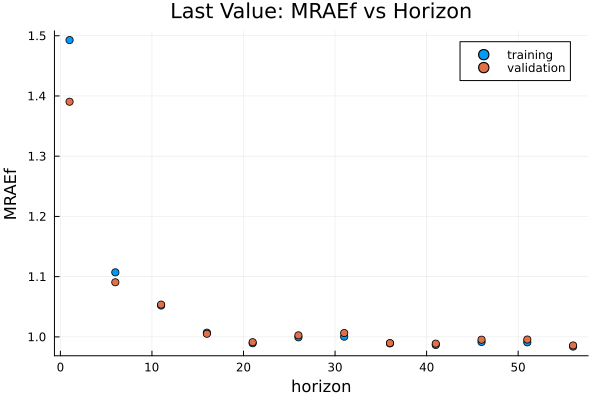

[ Info: Functions set
[ Info: Calculated on training set
[ Info: Calculated on validation set


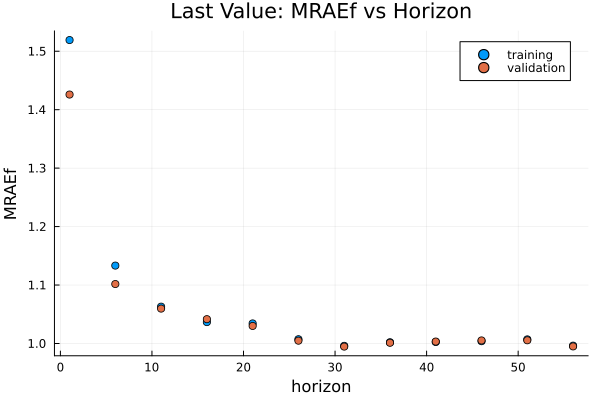

[ Info: Functions set
[ Info: Calculated on training set
[ Info: Calculated on validation set


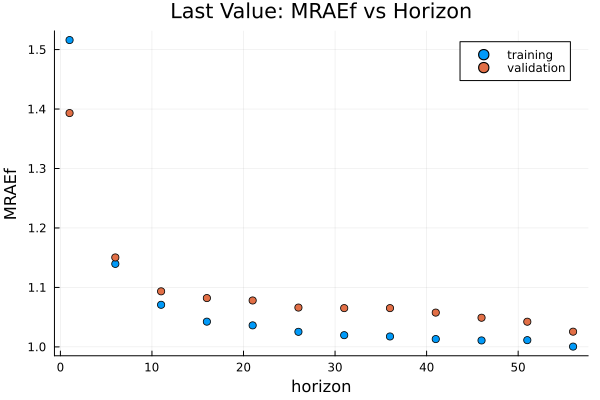

In [29]:
for maxSimIter = [20,30,60]#]#,
    rscope = "Forecast"
    LV_obj(params) = generic_μ_MAE_obj(params, LV_param_order; 
        extra=LV_extra, maxSimIter=maxSimIter, warmUpData=returnHistoryWarmUp,
        simEvents=trainingEvents, data=data[data.date .>= trainingEvents[1].date,:],relative_scope=rscope, target_data=train_μFcastMat)

    LV_obj_val(params) = generic_μ_MAE_obj(params, LV_param_order; 
        extra=LV_extra, maxSimIter=maxSimIter, warmUpData=returnHistoryStartData_Validation,
        simEvents=validationEvents, data=data[data.date .>= validationEvents[1].date,:], relative_scope=rscope, target_data=val_μFcastMat)

    range = 1:5:60
    @info "Functions set"
    errorVsHorizon_LV = [LV_obj([i]) for i=range]
    @info "Calculated on training set"
    errorValVsHorizon_LV = [LV_obj_val([i]) for i=range]
    @info "Calculated on validation set"
    using Plots:scatter, savefig,scatter!
    plotd=scatter(range, errorVsHorizon_LV, title="Last Value: MRAEf vs Horizon", xlabel="horizon",ylabel="MRAEf",label="training")
    scatter!(range, errorValVsHorizon_LV, label="validation")
    fig_dir = joinpath(@__DIR__, "figures")
    savefig(plotd,joinpath(fig_dir,"E1_01_LV_Optimization_$(maxSimIter)_days_MRAEf.svg"))
    display(plotd)
end

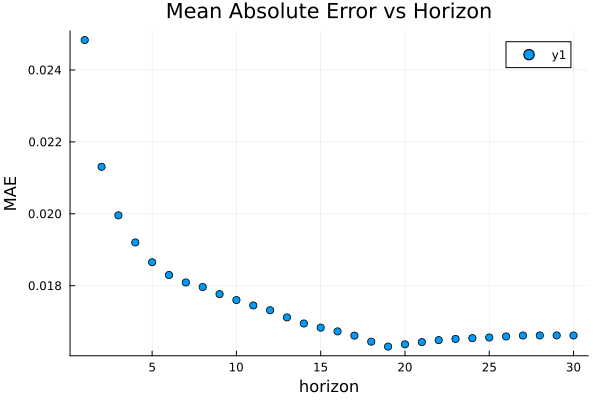

In [15]:
using Plots:scatter, savefig
plotd=scatter(1:30, errorVsHorizon_LV, title="Mean Absolute Error vs Horizon", xlabel="horizon",ylabel="MAE")
savefig(plotd,joinpath(fig_dir,"E1_01_LV_Optimization.svg"))
display(plotd)

### Tuning of Linear Regression

In [31]:
LR_extra = Dict(     
    "futureHorizon"=>futureHorizon, 
    "elementWise"=>true, # Forecast each company independently
    "symbolOrder"=>deepcopy(traded_assets),
    "forcastFunction"=>LR_Forecast,
    "forecastResult"=>[], 
    "varianceWindowSize"=>0,
)
LR_param_opt_config = Dict(
    "expectedReturnWindowSize"=>Dict("from"=>0,"to"=>30,"granularity"=>1,"initialValue"=>8),
    "pastHorizon"=>Dict("from"=>0,"to"=>60,"granularity"=>1,"initialValue"=>7),
)

LR_param_order= string.(collect(keys(LR_param_opt_config)))
@info "Optimizing Parameters" LR_param_opt_config

maxSimIter=20
# LR_obj(params) = generic_μ_MAE_obj(params, LR_param_order; extra=LR_extra)
LR_obj(params) = generic_μ_MAE_obj(params, LR_param_order; 
        extra=LR_extra, maxSimIter=maxSimIter, warmUpData=returnHistoryWarmUp,
        simEvents=trainingEvents, data=data[data.date .>= trainingEvents[1].date,:],relative_scope=rscope, target_data=train_μFcastMat)

LR_optimal_params = optimize_parameters(LR_obj,LR_param_opt_config; param_keys = LR_param_order)
@info "Optimal Parameters" LR_optimal_params

┌ Info: Optimizing Parameters
│   LR_param_opt_config =
│    Dict{String, Dict{String, Int64}} with 2 entries:
│      "pastHorizon"              => Dict("granularity"=>1, "initialValue"=>7, …
└      "expectedReturnWindowSize" => Dict("granularity"=>1, "initialValue"=>8, …


MADS Run Summary
------------------------------------------------
Feasible Solution           [21.0, 17.0]
Feasible Cost               0.9777365493765949
Infeasible Solution         nothing
Infeasible Cost             nothing

Iterations                  72
Function Evaluations        66
Cache hits                  219
Optimization Status         Mesh Precision limit

Runtime                     303.73638701438904
Search Time                 9.900000000000009e-6
Poll Time                   0.0063331
Blackbox Evaluation Time    242.6324302999988


┌ Info: Optimal Parameters
│   LR_optimal_params =
│    2-element Vector{Float64}:
│     21.0
└     17.0


##### Produce Figures for report on error vs parameter value on 3 sample sizes

In [32]:
LR_param_order

2-element Vector{String}:
 "pastHorizon"
 "expectedReturnWindowSize"

In [34]:

expectedReturnWindowSize_s = [1  5 10 15 20 30] #:5:60
pastHorizon_s = [2 5 10 15 20 30]
errorVsHorizon_LR =zeros(length(expectedReturnWindowSize_s),length(pastHorizon_s))
errorValVsHorizon_LR =zeros(length(expectedReturnWindowSize_s),length(pastHorizon_s))
for maxSimIter = [20]#,30,60]
    rscope = "Forecast"
    LR_obj(params) = generic_μ_MAE_obj(params, LR_param_order; 
        extra=LR_extra, maxSimIter=maxSimIter, warmUpData=returnHistoryWarmUp,
        simEvents=trainingEvents, data=data[data.date .>= trainingEvents[1].date,:],relative_scope=rscope, target_data=train_μFcastMat)

    LR_obj_val(params) = generic_μ_MAE_obj(params, LR_param_order; 
        extra=LR_extra, maxSimIter=maxSimIter, warmUpData=returnHistoryStartData_Validation,
        simEvents=validationEvents, data=data[data.date .>= validationEvents[1].date,:], relative_scope=rscope, target_data=val_μFcastMat)

    @info "Functions set"
    for  i=1:length(expectedReturnWindowSize_s), j=1:length(pastHorizon_s)
        expectedReturnWindowSize= expectedReturnWindowSize_s[i]
        pastHorizon = pastHorizon_s[j]
        errorVsHorizon_LR[i,j] = LR_obj([pastHorizon expectedReturnWindowSize])
        errorValVsHorizon_LR[i,j] = LR_obj_val([pastHorizon expectedReturnWindowSize])
        @info "[$(expectedReturnWindowSize), $(pastHorizon)] : $(errorVsHorizon_LR[i,j]), $(errorValVsHorizon_LR[i,j])"
    end
    errorVsHorizon_LR = [[LR_obj([i j]) for i=expectedReturnWindowSize_s] for j=pastHorizon_s]
    @info "Calculated on training set"
    errorValVsHorizon_LR = [[LR_obj_val([i j ]) for i=expectedReturnWindowSize_s] for j=pastHorizon_s]
    @info "Calculated on validation set"
    using Plots:scatter, savefig,scatter!
    plotd=scatter(range, errorVsHorizon_LV, title="Last Value: MRAEf vs Horizon", xlabel="horizon",ylabel="MRAEf",label="training")
    scatter!(range, errorValVsHorizon_LV, label="validation")
    fig_dir = joinpath(@__DIR__, "figures")
    savefig(plotd,joinpath(fig_dir,"E1_01_LR_Optimization_$(maxSimIter)_days_MRAEf.svg"))
    display(plotd)
    for i = 1:length(expectedReturnWindowSize_s)
        @info "expectedReturnWindowSize: $(expectedReturnWindowSize_s[i])"
        plotd = scatter(pastHorizon_s[:], errorVsHorizon_LR[i,:], title="Linear Regression: MRAEf vs Horizon", xlabel="horizon",ylabel="MRAEf",label="training - $(expectedReturnWindowSize_s[i])")
        scatter!(pastHorizon_s[:], errorValVsHorizon_LR[i,:], label="validation - $(expectedReturnWindowSize_s[i])")
        savefig(plotd,joinpath(fig_dir,"E1_01_LR_Optimization_expectedReturnWindowSize_$(expectedReturnWindowSize_s[i])_$(maxSimIter)_days_MRAEf.svg"))
        display(plotd)
    end
end

[ Info: Functions set
[ Info: [1, 2] : 6.771885344475016, 6.23101813225427
[ Info: [1, 5] : 2.496915155058229, 2.1701012068068986
[ Info: [1, 10] : 1.6373803941422909, 1.450347257863957
[ Info: [1, 15] : 1.3652789261278486, 1.2547066888171658
[ Info: [1, 20] : 1.2020148996397158, 1.1663720149860604
[ Info: [1, 30] : 1.1005467640362596, 1.0762880418079623
[ Info: [5, 2] : 1.9163782543340993, 1.7218304417998482
[ Info: [5, 5] : 1.582510456656229, 1.4425353318500467
[ Info: [5, 10] : 1.4627363443554295, 1.2931346623386957
[ Info: [5, 15] : 1.2862970330499948, 1.1919188375710388
[ Info: [5, 20] : 1.1646787329575412, 1.125985560997463
[ Info: [5, 30] : 1.0968482008138838, 1.0794856836091828
[ Info: [10, 2] : 1.3543040359039729, 1.2553885121663406
[ Info: [10, 5] : 1.2338396116027688, 1.156095363490553
[ Info: [10, 10] : 1.2039541413125163, 1.1385710740783141
[ Info: [10, 15] : 1.1565998398917434, 1.112342887704466
[ Info: [10, 20] : 1.1103418457518328, 1.0798684127855829
[ Info: [10, 30] : 

LoadError: LinearAlgebra.SingularException(2)

[ Info: expectedReturnWindowSize: 1


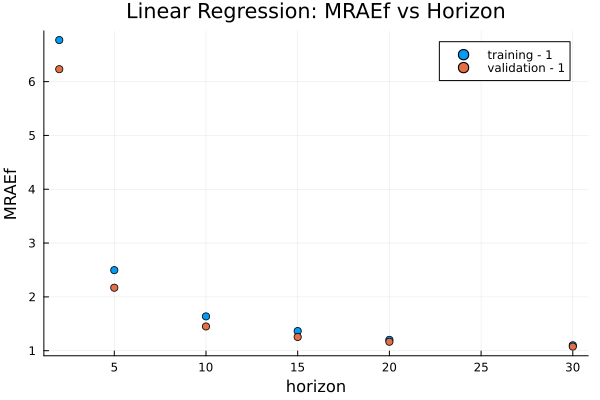

[ Info: expectedReturnWindowSize: 5


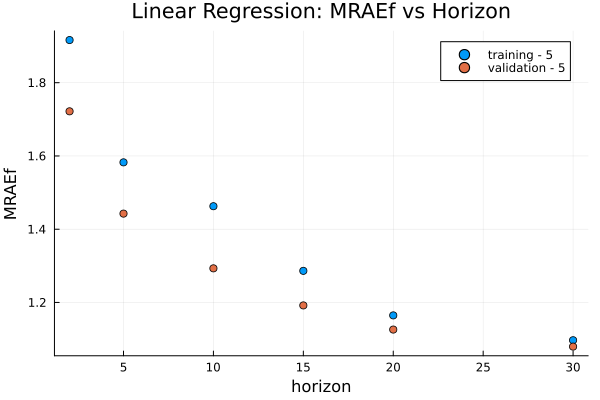

[ Info: expectedReturnWindowSize: 10


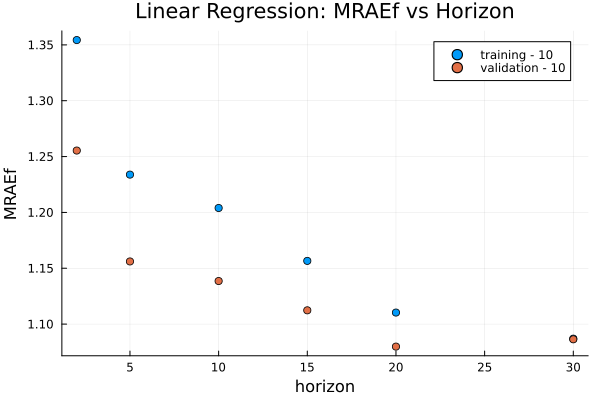

[ Info: expectedReturnWindowSize: 15


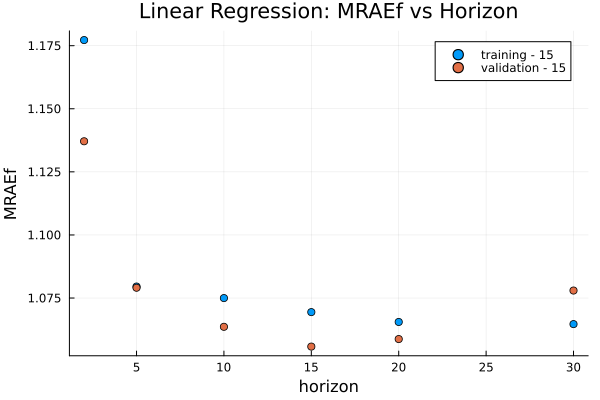

[ Info: expectedReturnWindowSize: 20


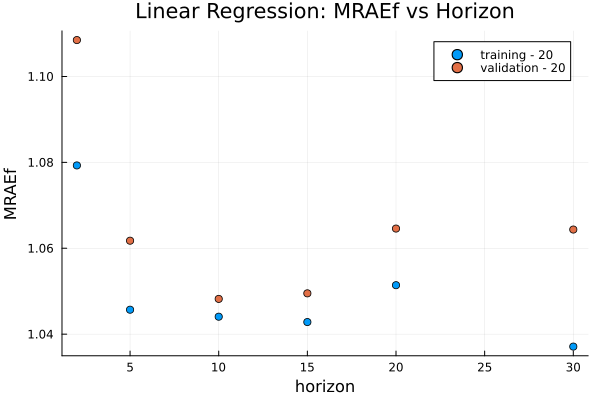

[ Info: expectedReturnWindowSize: 30


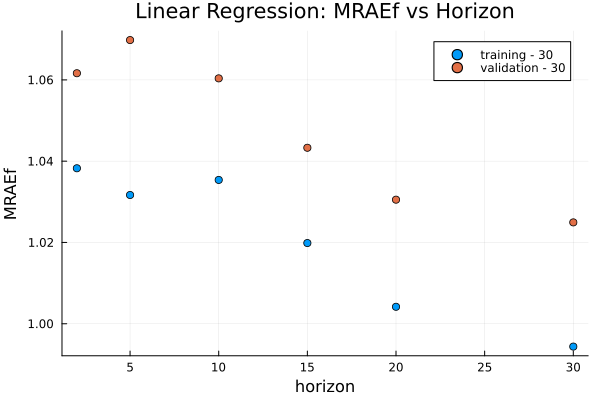

In [35]:
    for i = 1:length(expectedReturnWindowSize_s)
        @info "expectedReturnWindowSize: $(expectedReturnWindowSize_s[i])"
        plotd = scatter(pastHorizon_s[:], errorVsHorizon_LR[i,:], title="Linear Regression: MRAEf vs Horizon", xlabel="horizon",ylabel="MRAEf",label="training - $(expectedReturnWindowSize_s[i])")
        scatter!(pastHorizon_s[:], errorValVsHorizon_LR[i,:], label="validation - $(expectedReturnWindowSize_s[i])")
        savefig(plotd,joinpath(fig_dir,"E1_01_LR_Optimization_expectedReturnWindowSize_$(expectedReturnWindowSize_s[i])_$(maxSimIter)_days_MRAEf.svg"))
        display(plotd)
    end

### Tuning of behavioural

In [40]:
BH_extra = Dict(     
    "futureHorizon"=>futureHorizon, 
    "elementWise"=>true, # Forecast each company independently
    "symbolOrder"=>deepcopy(traded_assets),
    "forcastFunction"=>behaviouralForecast,
    "forecastResult"=>[], 
    "varianceWindowSize"=>0,
    "expectedReturnWindowSize"=>1, 
    "excludeCurrencyFromCalculation"=>true, # Behavioural & HMM: Reduce dimensionality of problem by 1
)

BH_param_opt_config = Dict(
    "pastHorizon"=>Dict("from"=>2,"to"=>60,"granularity"=>1,"initialValue"=>4),
)

rscope = "Forecast"
BH_param_order= string.(collect(keys(BH_param_opt_config)))
BH_obj(params) = generic_μ_MAE_obj(params, BH_param_order; 
        extra=BH_extra, maxSimIter=20, warmUpData=returnHistoryWarmUp,
        simEvents=trainingEvents, data=data[data.date .>= trainingEvents[1].date,:], target_data=train_μFcastMat, relative_scope=rscope)


BH_obj (generic function with 1 method)

In [41]:
@info "Optimizing Parameters" BH_param_order
BH_optimal_params = optimize_parameters(BH_obj,
    BH_param_opt_config; param_keys = BH_param_order)
@info "Optimal Parameters" BH_optimal_params

┌ Info: Optimizing Parameters
│   BH_param_order =
│    1-element Vector{String}:
└     "pastHorizon"


MADS Run Summary
------------------------------------------------
Feasible Solution           [4.0]
Feasible Cost               3.3340623628811286
Infeasible Solution         nothing
Infeasible Cost             nothing

Iterations                  50
Function Evaluations        3
Cache hits                  98
Optimization Status         Mesh Precision limit

Runtime                     25.693917989730835
Search Time                 7.199999999999995e-6
Poll Time                   0.0018072
Blackbox Evaluation Time    17.25602199999997


┌ Info: Optimal Parameters
│   BH_optimal_params =
│    1-element Vector{Float64}:
└     4.0


[ Info: Functions set: Behavioural
[ Info: [ 2] : 2.8122714301731007, 2.024839175873302
[ Info: [ 5] : 40.84496617564918, 9.53805944867871
[ Info: [ 10] : 7.455575859037843, 2.9799917190516965
[ Info: [ 15] : 129.19889027904955, 3.1010562969235234
[ Info: [ 20] : 22.13373477052711, 5.13279161903069
[ Info: [ 25] : 11.40996570152762, 19.38344092042024
[ Info: [ 30] : 7.881171384905876, 7.608265437358417
[ Info: [ 35] : 14.130601440408585, 7.1138409157596065
[ Info: [ 40] : 0.21313209198926258, 0.23966798901173594
[ Info: [ 45] : 0.21313209198926647, 0.23966798901174688
[ Info: [ 50] : 0.21313209198926977, 0.23966798901174505


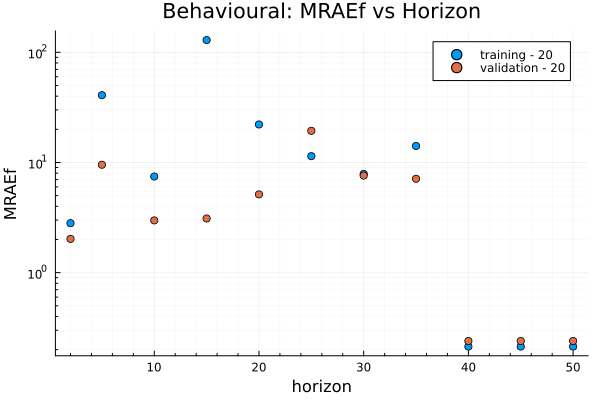

[ Info: Functions set: Behavioural
[ Info: [ 2] : 4.022238519248284, 6.929289558960651
[ Info: [ 5] : 7.348140292194032, 34.68655684639664
[ Info: [ 10] : 12.008742056491423, 13.43936556207386
[ Info: [ 15] : 23.78102530202442, 26.049302969868197
[ Info: [ 20] : 46.521042778630466, 7.527227526402584
[ Info: [ 25] : 42.08333751382074, 10.812713393219926
[ Info: [ 30] : 10.197976145590376, 10.91012876750584
[ Info: [ 35] : 28.36364387992266, 11.001467048185392
[ Info: [ 40] : 44.141394730039124, 29.54766518006315
[ Info: [ 45] : 63.71127706946127, 75.30290725011686
[ Info: [ 50] : 118.48829918249686, 72.49907990541031


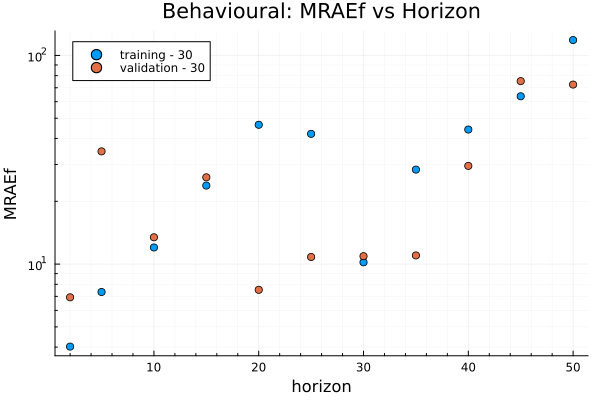

[ Info: Functions set: Behavioural
[ Info: [ 2] : 3.4963331734119785, 7.449864980756203
[ Info: [ 5] : 5.336374319710126, 55.0764710432294
[ Info: [ 10] : 29.366239716019674, 8.60871204092488
[ Info: [ 15] : 15.197480129735485, 8.85481800323391
[ Info: [ 20] : 32.395772506226734, 42.79526694019814
[ Info: [ 25] : 34.36628077518371, 39.91211532337262
[ Info: [ 30] : 7.2442551836308615, 21.9568687518095
[ Info: [ 35] : 14.497547047188874, 37.81903706421702
[ Info: [ 40] : 21.205333476194696, 8.932172618566128
[ Info: [ 45] : 37.44525224001636, 11.677868851723087
[ Info: [ 50] : 113.27113376517215, 5.376462866989184


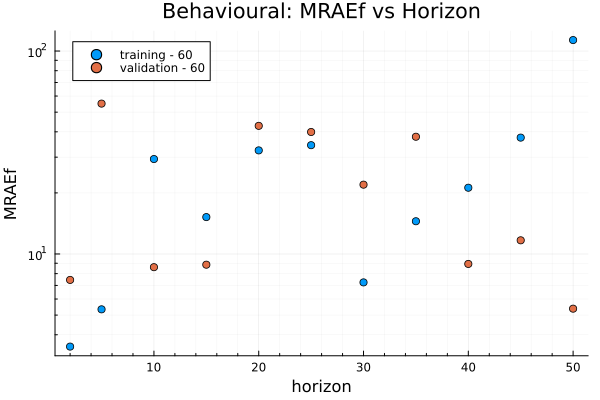

[ Info: Done


In [43]:

pastHorizon_s = [ 2 5 10 15 20 25 30 35 40 45 50]
errorVsHorizon_BH =zeros(length(pastHorizon_s))
errorValVsHorizon_BH =zeros(length(pastHorizon_s))
for maxSimIter = [20,30,60]
    rscope = "Forecast"
    BH_obj(params) = generic_μ_MAE_obj(params, BH_param_order; 
        extra=BH_extra, maxSimIter=maxSimIter, warmUpData=returnHistoryWarmUp,
        simEvents=trainingEvents, data=data[data.date .>= trainingEvents[1].date,:],relative_scope=rscope, target_data=train_μFcastMat)

    BH_obj_val(params) = generic_μ_MAE_obj(params, BH_param_order; 
        extra=BH_extra, maxSimIter=maxSimIter, warmUpData=returnHistoryStartData_Validation,
        simEvents=validationEvents, data=data[data.date .>= validationEvents[1].date,:], relative_scope=rscope, target_data=val_μFcastMat)
    @info "Functions set: Behavioural"
    for j=1:length(pastHorizon_s)
        pastHorizon = pastHorizon_s[j]
        errorVsHorizon_BH[j] = BH_obj([pastHorizon ])
        errorValVsHorizon_BH[j] = BH_obj_val([pastHorizon ])
        @info "[ $(pastHorizon)] : $(errorVsHorizon_BH[j]), $(errorValVsHorizon_BH[j])"
    end
    plotd = scatter(pastHorizon_s[:], errorVsHorizon_BH[:], title="Behavioural: MRAEf vs Horizon", xlabel="horizon",ylabel="MRAEf",label="training - $(maxSimIter)", yscale=:log10, minorgrid=true)
    scatter!(pastHorizon_s[:], errorValVsHorizon_BH[:], label="validation - $(maxSimIter)")
    savefig(plotd,joinpath(fig_dir,"E1_01_BH_Optimization_$(maxSimIter)_days_MRAEf.svg"))
    display(plotd)
end
@info "Done"

### Tuning of Hidden Markov Model
HMM uses a long horizon of data to estimate fit the probability distributions of market regimes as well as the transition probability between states.

The parameter to optimize in this case would be the number of states and amount of data fed to calibrate it and the frequency of recalibration of the MMM distributions. 

Due to the large amounts of data required for this method, and the publication giving evidence that 2 states were enough to model equity returns the tuning for this method is skipped.

### Comparison of forecast methods
Here the previous methods (already tuned) will be compared against each other in terms of their mean relative and absolute error on the forecast domain.

In [124]:
# Parameters and Extras
BH_extra = Dict(     
    "futureHorizon"=>futureHorizon, 
    "elementWise"=>true, # Forecast each company independently
    "symbolOrder"=>deepcopy(traded_assets),
    "forcastFunction"=>behaviouralForecast,
    "forecastResult"=>[], 
    "varianceWindowSize"=>0,
    "expectedReturnWindowSize"=>1, 
    "excludeCurrencyFromCalculation"=>true, # Behavioural & HMM: Reduce dimensionality of problem by 1
)

BH_param = Dict(
    "pastHorizon"=>4
)

LR_extra = Dict(     
    "futureHorizon"=>futureHorizon, 
    "elementWise"=>true, # Forecast each company independently
    "symbolOrder"=>deepcopy(traded_assets),
    "forcastFunction"=>LR_Forecast,
    "forecastResult"=>[], 
    "varianceWindowSize"=>0,
)
LR_param = Dict(
    "expectedReturnWindowSize"=>19,
    "pastHorizon"=>8,
)


LV_extra = Dict(     
    "futureHorizon"=>futureHorizon, 
    "symbolOrder"=>deepcopy(traded_assets),
    "forcastFunction"=>LV_Forecast,
    "forecastResult"=>[], 
    "varianceWindowSize"=>0,
)

LV_param = Dict(
    "expectedReturnWindowSize"=>58,
)

HMM_extra = Dict( 
    "futureHorizon"=>futureHorizon, # 
    "symbolOrder"=>deepcopy(traded_assets),
    "forcastFunction"=>hmmForecast,
    "hmm"=>nothing, # Initial Hidden Markov Model
    "obs_seq"=>[], # Initial Warm-Start Data
    "lastScanIx"=>1, # Index to keep track of not yet ingested data.
    "excludeCurrencyFromCalculation"=>true, # Behavioural & HMM: Reduce dimensionality of problem by 1
    "forecastResults"=>[], 
)

HMM_param = Dict( 
    "recalibrationPeriod"=>50 # Index to keep track of not yet ingested data.
)

function generic_μ_MAE_obj_perDomain(extra, param; 
        relative_scope=nothing, maxSimIter=20, warmUpData=returnHistoryWarmUp,
        simEvents=trainingEvents, data=data,target_data=target_data) 
    # Produce forecast
    init!(context) =  general_initialize!(context,extra,param; returnHistoryStartData=returnHistoryWarmUp)
    context = DEDS.run(data, init!, forcastTradingLogic!,my_execute_orders!,my_expose_data; verbose=false, audit=true, max_iter=maxSimIter, initialEvents=deepcopy(simEvents))
    
    # Structure result and fetch target values
    μFcastMat=produce_μFcastMat(context)
    N = size(μFcastMat)[3] # Forecast instances
    D = size(μFcastMat)[2] # Domain length
    A = size(μFcastMat)[1] # Number of assets
    
    # @info " FcastMat Dimensions" N D A
    
    target = target_data[:,:,1:N] # Array structure: AssetIx - Forcast domain - Forecast instance
    N1(x)  = sum(abs.(x)) # Norm-1
    errorVec = zeros(D)
    
    for e_ix=1:D
        if isnothing(relative_scope)
            errorVec[e_ix] = mean(
                [N1(μFcastMat[:,e_ix,:]-target[:,e_ix,:]) for i=1:N])  # Not scaled
        elseif relative_scope == "All" 
            errorVec[e_ix] = mean([N1(μFcastMat[:,e_ix,:]-target[:,e_ix,:]) ./ N1(target[:,e_ix,:]) for i=1:N])
        elseif relative_scope == "Forecast" 
            errorVec[e_ix] =  mean([N1(μFcastMat[:,e_ix,i]-target[:,e_ix,i]) ./ N1(target[:,e_ix,i]) for i=1:N])
        end
    end 
    return errorVec
end

# HMM_vs_days = vsDayFun(HMM_extra, HMM_param)

# generic_μ_MAE_obj_perDomain(extra, param; relative_scope=nothing, maxSimIter=20, warmUpData=returnHistoryWarmUp,
        # simEvents=trainingEvents, data=data,target_data=target_data) 


generic_μ_MAE_obj_perDomain (generic function with 1 method)

In [125]:
maxSimIter=length(validationEvents)
rscope="Forecast"
vsDayFun(extra,param) = generic_μ_MAE_obj_perDomain(extra, param; maxSimIter=maxSimIter, warmUpData=returnHistoryStartData_Validation,
        simEvents=validationEvents, data=data[data.date .>= validationEvents[1].date,:], relative_scope=rscope, target_data=val_μFcastMat)
LV_vs_days = vsDayFun(LV_extra, LV_param)
LR_vs_days = vsDayFun(LR_extra, LR_param)
BH_vs_days = vsDayFun(BH_extra, BH_param)


7-element Vector{Float64}:
 14.190730361787153
 20.680426380238796
 12.643230101545145
 16.27646610486814
 15.950298955359512
 22.00935394654639
 13.371637946343293

In [153]:

HMM_extra = Dict( 
    "futureHorizon"=>futureHorizon, # 
    "symbolOrder"=>deepcopy(traded_assets),
    "forcastFunction"=>hmmForecast,
    "hmm"=>nothing, # Initial Hidden Markov Model
    "obs_seq"=>[], # Initial Warm-Start Data
    "lastScanIx"=>1, # Index to keep track of not yet ingested data.
    "excludeCurrencyFromCalculation"=>true, # Behavioural & HMM: Reduce dimensionality of problem by 1
    "forecastResults"=>[], 
)
# Recalibration pt
HMM_param = Dict( 
    "recalibrationPeriod"=>500 # Index to keep track of not yet ingested data.
)
HMM_vs_days = vsDayFun(HMM_extra, HMM_param)

7-element Vector{Float64}:
 1.0067383904843006
 1.0065177708762465
 1.0066401996847059
 1.006665714059787
 1.00639903708459
 1.0057926407909183
 1.0061549197490898

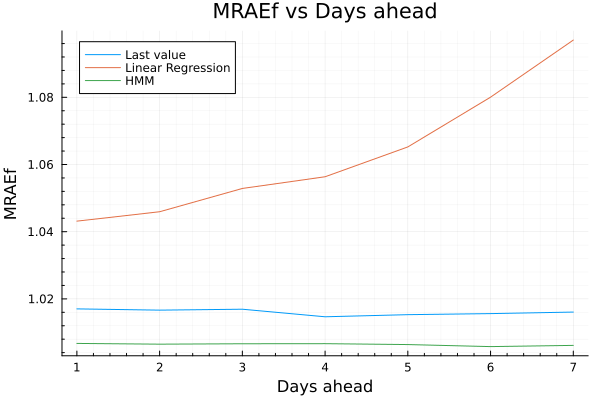

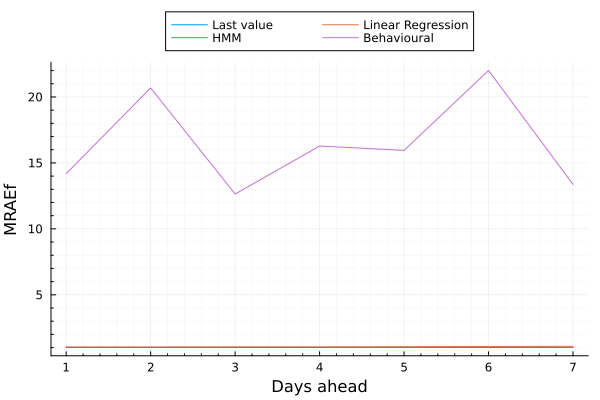

In [154]:
using Plots: plot, plot!
plotd = plot(1:futureHorizon,LV_vs_days,label="Last value",title="MRAEf vs Days ahead", xlabel="Days ahead", ylabel="MRAEf",  minorgrid=true)
plot!(1:futureHorizon,LR_vs_days,label="Linear Regression")
plot!(1:futureHorizon,HMM_vs_days,label="HMM")
savefig(plotd,joinpath(fig_dir,"E1_01_methodComparison_wo_BH.svg"))
display(plotd)
plot!(1:futureHorizon,BH_vs_days,label="Behavioural",legend=:outertop,legend_columns=2,title="")
savefig(plotd,joinpath(fig_dir,"E1_01_methodComparison.svg"))
display(plotd)


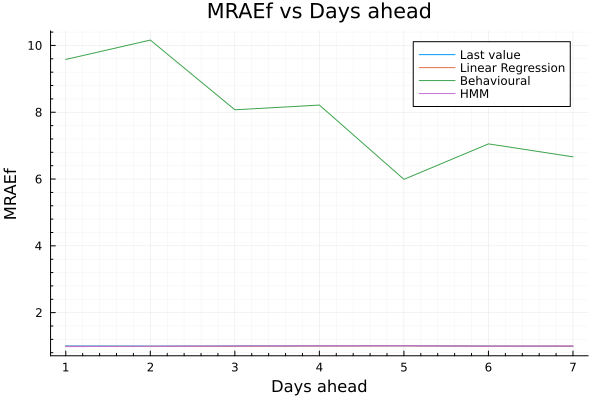

In [150]:
using Plots: plot, plot!
plotd = plot(1:futureHorizon,LV_vs_days,label="Last value",title="MRAEf vs Days ahead", xlabel="Days ahead", ylabel="MRAEf", minorgrid=true)
plot!(1:futureHorizon,LR_vs_days,label="Linear Regression")
plot!(1:futureHorizon,BH_vs_days,label="Behavioural")
plot!(1:futureHorizon,HMM_vs_days,label="HMM")



# Backtesting
Now we shall compare the performance of each method by running a simulation over time of them using the AirBorne DEDS simulation engine with a customized trading logic method that solely performs the forecasting on each simulation event.

In [178]:
using Plots: plot, plot!, savefig, scatter, scatter!
using AirBorne.Markets.StaticMarket: execute_orders!, expose_data, executeOrder_CA!

dollar_symbol = "FEX/USD"
feeStructure=Vector{Dict}([Dict("FeeName" => "SaleCommission", "fixedPrice" => 0.0, "variableRate" => 0.02)])

### Market Operations
# In this strategy we want to reflect the money in our accounts in the portfolio composition
# By default a 2% fee commission is going to be taken from each sale
singleExecutionFun(context, order, data) = executeOrder_CA!(context, order, data;defaultFeeStructures=feeStructure,partialExecutionAllowed=false)
my_execute_orders!(context, data) = execute_orders!(context, data; propagateBalanceToPortfolio=true, executeOrder=singleExecutionFun)
my_expose_data(context,data) = expose_data(context,data; historical=false)

# MPC problem with horizon 7, 2% commission cost on sale, and total disregard of quadratic terms
core_MPC_parameters = Dict()
core_MPC_extras= Dict("futureHorizon"=>7,"propCost"=>0.03,"riskWeight"=>0.0, "symbolOrder" => collect(unique(data.assetID)))

# PostProcessing Data
using AirBorne.Structures: summarizePerformance
using Plots: plot
usdData = deepcopy(data[data.assetID .== traded_assets[1], :])
usdData[!, "assetID"] .= dollar_symbol
usdData[!, "exchangeName"] .= "FEX"
usdData[!, "symbol"] .= "USD"
usdData[!, [:close, :high, :low, :open]] .= 1.0
usdData[!, [:volume]] .= 0
OHLCV_data = vcat(data, usdData)
@info "Backtesting common parameters defined"

tradedAssets_wo_currency = deepcopy(unique(data.assetID))
tradedAssets_w_currency = deepcopy(tradedAssets_wo_currency)
push!(tradedAssets_w_currency,"FEX/USD")

warmUpData_backtest=data[data.date .< backtestingEvents[1].date,:]
data_backtest_wo_currency = data[data.date .>= backtestingEvents[1].date,:] # No FEX/USD
data_backtest_w_currency = OHLCV_data[OHLCV_data.date .>= backtestingEvents[1].date,:] # This has FEX/USD
@info "Backtesting datasets defined"

[ Info: Backtesting common parameters defined
[ Info: Backtesting datasets defined


In [95]:
# MPC Trading logic
using AirBorne.Utils: sortedStructInsert!, rvcat, rblockdiag
using AirBorne.Structures: ContextTypeA, c_get
using AirBorne.Markets.StaticMarket: Order, place_order!, ordersForPortfolioRedistribution
using AirBorne.ETL.AssetValuation: stockValuation, returns, covariance

# External Dependencies
using Dates: DateTime
using DataFrames: DataFrame
using DotMaps: DotMap
using JuMP:
    @variable, @expression, Model, @objective, @constraint, optimize!, @NLobjective, value, set_silent
using SparseArrays: sparse, I, spdiagm
using Ipopt: Ipopt
import MathOptInterface as MOI


function MPC_tradingLogic!(context, data; forecastFun::Function=perfectForecastReturns)
    ####  Update data  ####
    if size(data, 1) == 0 # No New data, nothing to do
        return nothing
    end
    context.extra.pastValue = context.extra.currentValue

    context.extra.currentValue = stockValuation(data)
    context.extra.currentValue[!, context.extra.currency_symbol] .= 1.0 # Add currency to values

    [push!(context.extra.valueHistory, r) for r in eachrow(context.extra.currentValue)]

    if size(context.extra.pastValue, 1) > 0 # Add new data to history record
        r1 = returns(vcat(context.extra.pastValue, context.extra.currentValue))
        push!(context.extra.returnHistory, r1[end, :])
    end

    ####  MPC  ####
    if size(context.extra.returnHistory, 1) < context.extra.min_data_samples
        return nothing # Not enough history data to continue
    end

    # Forecasts
    meanVarianceForecast = forecastFun(context) # Returns a sequence of Return vectors and Covariance matrices

    # Matrices Definitions
    r = float.(rvcat([reshape(rV[1],:,1) for rV in meanVarianceForecast])) # Return Vector
    Q = rblockdiag([rV[2] for rV in meanVarianceForecast]) # Block diagonal with covariance matrices in the diagonal
    𝛾_trade = c_get(context, "propCost", 0.05)
    𝛾_risk = c_get(context, "riskWeight", 0.0)
    n_assets = length(context.extra.symbolOrder)
    T = length(meanVarianceForecast)
    B1 = kron(sparse(I, T, T), ones(1, n_assets)) # Matrix such that when multiplied by X, it returns a vector of ones of length T

    # Optimization Problem
    model = Model(Ipopt.Optimizer)
    set_silent(model)
    
    @variable(model, x[1:length(r)] >= 0)
    @variable(model, sum_portfolio_differences)
    @constraint(model,
        [sum_portfolio_differences; x[1:(end - n_assets)] - x[(n_assets + 1):end]
            ] in MOI.NormOneCone(1 + length(x) - n_assets)) # Norm-1
    @objective(model, Min, sum([-r[i] * x[i] for i=1:length(r)]) + 𝛾_trade * sum_portfolio_differences + 𝛾_risk * (x' * Q * x))
    @constraint(model, B1 * x .- ones(T, 1) .== 0)
    optimize!(model)
    sol = round.(value.(x)[1:n_assets]; digits=3) # Best next portfolio distribution

    # Decode solution into buy/sell orders
    assetPricing = context.extra.currentValue[1, "stockValue"]
    assetPricing[context.extra.currency_symbol] = 1.0
    orders = ordersForPortfolioRedistribution(
        convert(Dict{String,Float64}, context.portfolio),
        Dict([context.extra.symbolOrder[i] => sol[i] for i in 1:n_assets]),
        assetPricing;
        account=context.accounts.usd,
        curency_symbol=context.extra.currency_symbol,
        costPropFactor=𝛾_trade,
    )
    [place_order!(context, order) for order in orders] # Place orders
    return nothing
end


MPC_tradingLogic! (generic function with 1 method)

## Perfect forecast backtest

[ Info: Done


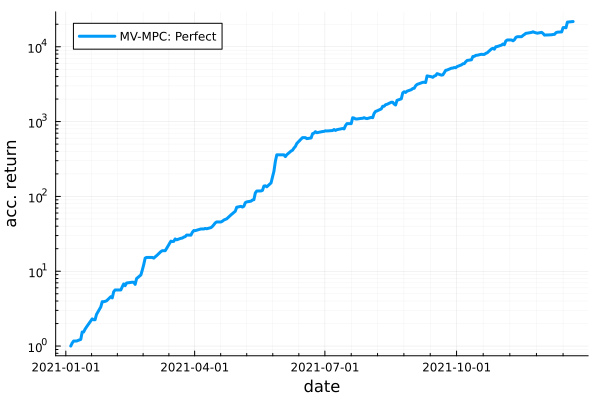

In [157]:

# for pcost = [0.0,0.01, 0.02,0.03,  0.04, 0.05]
for pcost = [0.05]
    PF_params = Dict()
    PF_extras= Dict(
        "futureHorizon"=>7,
        "propCost"=>pcost,
        "riskWeight"=>0.0,
        "symbolOrder" => collect(unique(data.assetID)))

    # Define Perfect Forecasting Function
    PF_forecastFun(context) = perfectForecastReturns(context,sr)

    perfect_MPC_initialize!(context) = general_initialize!(context,PF_extras,PF_params; 
        returnHistoryStartData=returnHistoryStartData_Backtest)  
    perfect_MPC_TL!(context, data) = MPC_tradingLogic!(context, data; forecastFun=PF_forecastFun)

    PF_Backtest_Context = DEDS.run(
        data_backtest_wo_currency,
        perfect_MPC_initialize!,
        perfect_MPC_TL!,
        my_execute_orders!,
        my_expose_data;
        audit=true,
        verbose=true,
        initialEvents=deepcopy(backtestingEvents),
        )

    pf_results = summarizePerformance(OHLCV_data, PF_Backtest_Context; includeAccounts=false)
    PF_Backtest_Context = nothing;  GC.gc() 

    pf_acc_return = pf_results.dollarValue ./pf_results.dollarValue[1]
    pf_dates = pf_results.date
    @info "Done"

    plotd=plot(pf_dates, pf_acc_return, label="MV-MPC: Perfect", xlabel="date", 
        ylabel="acc. return", linewidth=3, yscale=:log10, minorgrid=true, legend=:topleft)
    fig_dir = joinpath(@__DIR__, "figures")
    savefig(plotd,joinpath(fig_dir,"E1_02_PF_Forecast_$(pcost).svg"))
    display(plotd)
end

## Last Value backtest

**Last Value** can also provide an estimation of the covariance matrix, therefore a sense of risk as a variability of the prediction can be applied. Therefore the riskWeight will be passed as a parameter. 

[ Info: Done


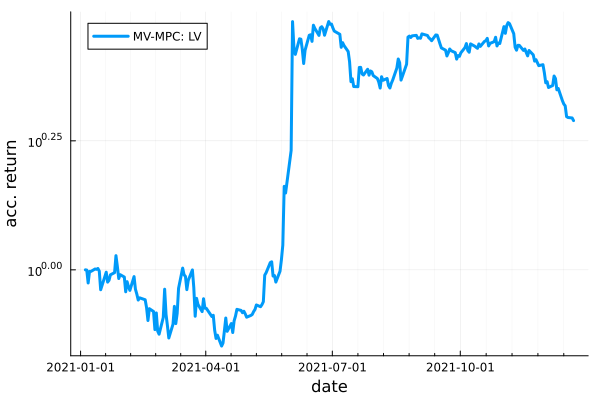

In [193]:
LV_params = merge(core_MPC_parameters,Dict(
        "riskWeight"=>1.2,
        "varianceWindowSize"=>51,
        "expectedReturnWindowSize"=>59,
        ))
LV_extras = merge(core_MPC_extras,Dict())

LV_MPC_initialize!(context) = general_initialize!(context,LV_extras,LV_params; returnHistoryStartData=returnHistoryStartData_Backtest)  
LV_MPC_TL!(context, data) = MPC_tradingLogic!(context, data; forecastFun=LV_Forecast)

LV_Backtest_Context = DEDS.run(
        data_backtest,
        LV_MPC_initialize!,
        LV_MPC_TL!,
        my_execute_orders!,
        my_expose_data;
        audit=true,
        verbose=true,
        initialEvents=deepcopy(backtestingEvents),
    )
lv_results = summarizePerformance(OHLCV_data, LV_Backtest_Context; includeAccounts=false)
LV_Backtest_Context = nothing;  GC.gc()

lv_acc_return = lv_results.dollarValue ./lv_results.dollarValue[1]
lv_dates = lv_results.date
@info "Done"
plotd=plot(lv_dates, lv_acc_return, label="MV-MPC: LV", xlabel="date",ylabel="acc. return", linewidth=3, yscale=:log10, minorgrid=true)
savefig(plotd,joinpath(fig_dir,"E1_02_LV_Forecast_$(join(string.(values(LV_params)),"_")).svg"))
display(plotd)

### Hyperparameter optimization (LV-backtest)
Using the training period for backtesting the parameters for the variance and horizon can be optimized using the final dollar value of the portfolio as the objective function to be optimized

In [19]:
using AirBorne.ETL.AssetValuation: valuePortfolio
function generic_profit_obj(vec_params,param_keys_order, tradingLogic!,paramConfig; extra=Dict()) 
    maxSimIter=60 # Maximum days in simulation to evaluate parameters
    iteration_params = Dict([param_keys_order[i] => paramConfig[param_keys_order[i]]["parse"](vec_params[i]) for i=1:length(vec_params)])
    init!(context) =  general_initialize!(context,extra,iteration_params; returnHistoryStartData=returnHistoryWarmUp)
    #Run on train data
    context = DEDS.run(data, init!, tradingLogic!,my_execute_orders!,my_expose_data;
        verbose=false, audit=false, max_iter=maxSimIter, initialEvents=deepcopy(trainingEvents))
    final_value = valuePortfolio(context.portfolio, context.extra.currentValue[1,"stockValue"])
    @info "$(vec_params):$(final_value)"
    return -log10(final_value)
end

generic_profit_obj (generic function with 1 method)

In [188]:

LV_profit_param_opt_config = Dict(
    "riskWeight"=>Dict("from"=>0,"to"=>5,"granularity"=>0.2,"initialValue"=>1.0, "parse"=>float), # Not interested in optimizing variance now ,
    "varianceWindowSize"=>Dict("from"=>0,"to"=>60,"granularity"=>1,"initialValue"=>58, "parse"=>Int), # Not interested in optimizing variance now
    "expectedReturnWindowSize"=>Dict("from"=>0,"to"=>60,"granularity"=>1,"initialValue"=>58, "parse"=>Int)
)

LV_profit_param_order= string.(collect(keys(LV_profit_param_opt_config)))

LV_profit_extra = merge(core_MPC_extras,Dict())
LV_MPC_TL!(context, data) = MPC_tradingLogic!(context, data; forecastFun=LV_Forecast)
LV_profit_obj(params) = generic_profit_obj(params, LV_profit_param_order, LV_MPC_TL!, LV_profit_param_opt_config; extra=LV_profit_extra)

LV_profit_optimal_params = optimize_parameters(LV_profit_obj,LV_profit_param_opt_config)

@info "Optimal Parameters" LV_profit_optimal_params LV_profit_param_order


[ Info: [1.0, 58.0, 58.0]:157058.74980704597
[ Info: [0.8, 60.0, 53.0]:97865.49427331556
[ Info: [1.0, 53.0, 55.0]:115741.3988222547
[ Info: [0.8, 59.0, 57.0]:110712.92130264739
[ Info: [1.2, 60.0, 58.0]:134569.0998560713
[ Info: [1.0, 58.0, 60.0]:166483.1657398089
[ Info: [1.2, 57.0, 59.0]:186799.72021781423
[ Info: [0.8, 56.0, 58.0]:111992.28295250461
[ Info: [1.0, 58.0, 56.0]:108992.11709061559
[ Info: [1.6, 55.0, 58.0]:144166.4159962862
[ Info: [1.0, 52.0, 58.0]:130546.2553144216
[ Info: [0.8, 59.0, 60.0]:165716.047937061
[ Info: [1.2, 58.0, 54.0]:103913.82915528226
[ Info: [1.4, 58.0, 59.0]:183511.79158399918
[ Info: [1.2, 59.0, 60.0]:172211.98231509308
[ Info: [1.0, 56.0, 59.0]:186913.46251012463
[ Info: [1.2, 58.0, 57.0]:121145.66551966988
[ Info: [1.2, 55.0, 58.0]:133699.41660539334
[ Info: [1.4, 56.0, 58.0]:138144.8641655285
[ Info: [0.8, 57.0, 57.0]:108825.25985701059
[ Info: [0.6, 56.0, 60.0]:163848.91569703718
[ Info: [1.0, 51.0, 59.0]:197117.867421482
[ Info: [1.4, 44.0, 5

MADS Run Summary
------------------------------------------------
Feasible Solution           [0.4, 50.0, 59.0]
Feasible Cost               -5.301370880252387
Infeasible Solution         nothing
Infeasible Cost             nothing

Iterations                  60
Function Evaluations        77
Cache hits                  270
Optimization Status         Mesh Precision limit

Runtime                     842.3327949047089
Search Time                 1.070000000000001e-5
Poll Time                   0.0120256
Blackbox Evaluation Time    832.8957915000053


[ Info: [0.6, 49.0, 60.0]:181596.13165033926
┌ Info: Optimal Parameters
│   LV_profit_optimal_params =
│    3-element Vector{Float64}:
│      0.4
│     50.0
└     59.0


<!-- **Truncated Result:**

Given that the optimization method took too long to converge intermediate results were recorded below. Overall portfolio growths of around 1.5 can be seen with Expecations windows of 21 to 24, and variance windows larger than 6. The risk  factor seems to play a minor role, althought it may be a scaling issue.

| Risk | Variance Window | Expectation Window | Portfolio growth |
| --- | --- | --- | --- |
| 1.0 | 7.0 | 19.0 | 1.4095737111448199 |  
| 1.0 | 7.0 | 21.0 | 1.4613784532210163 |  
| 1.0 | 8.0 | 20.0 | 1.3989359669409043 |  
| 1.2 | 7.0 | 20.0 | 1.424935043454655  | 
| 1.0 | 7.0 | 17.0 | 1.1546552163248136 |  
| 1.0 | 6.0 | 18.0 | 1.1879620061791705 |  
| 0.8 | 7.0 | 18.0 | 1.1685441261639877 |  
| 1.2 | 7.0 | 21.0 | 1.4693113419942871 |  
| 1.0 | 6.0 | 26.0 | 1.198471065226556  | 
| 1.0 | 8.0 | 26.0 | 1.3045621820913584 |  
| 0.8 | 7.0 | 21.0 | 1.4810201159551426 |  
| 1.0 | 8.0 | 16.0 | 1.13090860299683   |
| 1.0 | 6.0 | 16.0 | 1.151857224939507  | 
| 0.4 | 8.0 | 21.0 | 1.4788212043341957 |  
| 1.2 | 8.0 | 21.0 | 1.47599216342706   |
| 0.8 | 7.0 | 26.0 | 1.2339418641463331 |  
| 1.2 | 6.0 | 21.0 | 1.485059371868302  | 
| 0.4 | 6.0 | 21.0 | 1.5617019542338717 |  
| 0.8 | 7.0 | 16.0 | 1.131773738364905  | 
| 1.0 | 4.0 | 18.0 | 1.17232769557884   |
| 1.4 | 6.0 | 26.0 | 1.1034357555336123 |  
| 1.2 | 8.0 | 17.0 | 1.1347626518522087 |  
| 0.6 | 7.0 | 20.0 | 1.346924415314058  | 
| 0.8 | 6.0 | 23.0 | 1.529751230308915  | 
| 0.2 | 7.0 | 23.0 | 1.6054889246995205 |  
| 0.2 | 5.0 | 22.0 | 1.6481386998558176 |  
| 0.0 | 6.0 | 19.0 | 1.529226290485336  | 
| 0.6 | 5.0 | 19.0 | 1.6508287601639382 |  
| 1.6 | 6.0 | 20.0 | 1.511041977871331  | 
| 1.0 | 3.0 | 15.0 | 1.1152817637556107 |  
| 0.8 | 3.0 | 24.0 | 1.4306552751559416 |  
| 0.4 | 7.0 | 14.0 | 1.180658754778854  | 
| 0.4 | 5.0 | 17.0 | 1.1246445078341345 |  
| 0.6 | 6.0 | 19.0 | 1.6078982854757322 |  
| 0.2 | 5.0 | 21.0 | 1.584344863351828  | 
| 0.8 | 5.0 | 21.0 | 1.4963483332408756 |  
| 0.6 | 4.0 | 19.0 | 1.6745567238637697 |  
| 1.0 | 5.0 | 17.0 | 1.1550441964345528 |  
| 1.0 | 5.0 | 19.0 | 1.639239329875483  | 
| 0.8 | 3.0 | 17.0 | 1.1464008268616437 |  
| 0.6 | 2.0 | 21.0 | 1.5493512331138761 |  
| 0.2 | 3.0 | 19.0 | 1.4845852316756687 |  
| 0.4 | 5.0 | 21.0 | 1.5133069490252062 |  
| 0.6 | 6.0 | 17.0 | 1.0987676133891302 |  
| 0.8 | 4.0 | 19.0 | 1.6773683052054869 |  
| 0.6 | 4.0 | 18.0 | 1.210109483816953  | 
| 0.6 | 3.0 | 19.0 | 1.5643202139613084 |  
| 0.4 | 4.0 | 19.0 | 1.6647471374804446 |  
| 0.6 | 4.0 | 20.0 | 1.3932321207232896 |  
| 0.6 | 3.0 | 18.0 | 1.190909241403082  | 
| 0.4 | 5.0 | 19.0 | 1.6005537801241143 |  
| 1.0 | 5.0 | 20.0 | 1.4497722411980258 |  
| 1.2 | 3.0 | 19.0 | 1.6317913224048368 |  
| 0.6 | 5.0 | 18.0 | 1.1762907975773267 |  
| 1.0 | 3.0 | 20.0 | 1.4470202766926958 |  
| 0.8 | 5.0 | 19.0 | 1.640106590286212  | 
| 0.8 | 3.0 | 19.0 | 1.6376439869211556 |  
| 0.8 | 3.0 | 20.0 | 1.4693367480117994 |  
| 0.8 | 5.0 | 18.0 | 1.1979945728611032 |  
| 1.0 | 4.0 | 19.0 | 1.6815487963828595 |  
| 0.8 | 4.0 | 18.0 | 1.2042202909320703 |  
| 0.8 | 4.0 | 20.0 | 1.4134875939794722 |  
| 1.4 | 4.0 | 20.0 | 1.446699876845205  | 
| 1.2 | 4.0 | 18.0 | 1.159834628645904  | 
| 1.2 | 4.0 | 19.0 | 1.687372378906131  |  -->

### Linear Regression Backtest


[ Info: Done


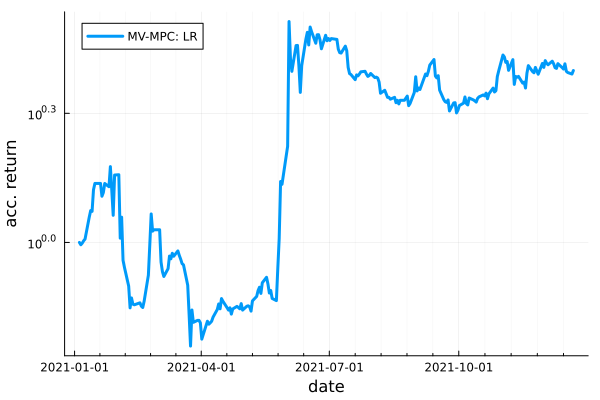

In [188]:
LR_extras = Dict(     
    "futureHorizon"=>futureHorizon, 
    "elementWise"=>true, # Forecast each company independently
    "symbolOrder"=>deepcopy(traded_assets),
    "forecastResult"=>[], 
)
LR_params = Dict(
    "riskWeight"=>0,
    "varianceWindowSize"=>0,
    "expectedReturnWindowSize"=>17,
    "pastHorizon"=>21,
)

LR_MPC_initialize!(context) = general_initialize!(context,LR_extras,LR_params; returnHistoryStartData=returnHistoryStartData_Backtest)  
LR_MPC_TL!(context, data) = MPC_tradingLogic!(context, data; forecastFun=LR_Forecast)

LR_Backtest_Context = DEDS.run(
        data_backtest,
        LR_MPC_initialize!,
        LR_MPC_TL!,
        my_execute_orders!,
        my_expose_data;
        audit=true,
        # max_iter=100, # Run for 100 business days
        verbose=true,
        initialEvents=deepcopy(backtestingEvents),
    )

olr_results = summarizePerformance(OHLCV_data, LR_Backtest_Context; includeAccounts=false)
LR_Backtest_Context = nothing;  GC.gc() 

olr_acc_return = olr_results.dollarValue ./olr_results.dollarValue[1]
olr_dates = olr_results.date
@info "Done"
plotd=plot(olr_dates, olr_acc_return, label="MV-MPC: LR", xlabel="date",ylabel="acc. return", linewidth=3, yscale=:log10, minorgrid=true)
savefig(plotd,joinpath(fig_dir,"E1_02_LR_Forecast_$(join(string.(values(LR_params)),"_")).svg"))
display(plotd)


## Behavioural Backtest

[ Info: Done


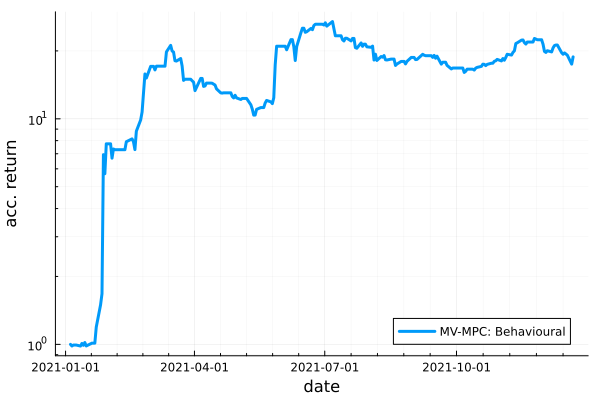

In [21]:

BH_params = merge(core_MPC_parameters,Dict(
        "pastHorizon"=>20
        ))
BH_extras = merge(core_MPC_extras,Dict())

BH_MPC_initialize!(context) = general_initialize!(context,BH_extras, BH_params; returnHistoryStartData=returnHistoryStartData_Backtest)  
BH_MPC_TL!(context, data) = MPC_tradingLogic!(context, data; forecastFun=behaviouralForecast)

BH_Backtest_Context = DEDS.run(
        data_backtest,
        BH_MPC_initialize!,
        BH_MPC_TL!,
        my_execute_orders!,
        my_expose_data;
        audit=true,
        verbose=true,
        initialEvents=deepcopy(backtestingEvents),
    )

@info "Done"
bh_results = summarizePerformance(OHLCV_data, BH_Backtest_Context; includeAccounts=false)
BH_Backtest_Context = nothing;  GC.gc() 


bh_acc_return = bh_results.dollarValue ./bh_results.dollarValue[1]
bh_dates = bh_results.date

plotd=plot(bh_dates, bh_acc_return, label="MV-MPC: Behavioural",xlabel="date",ylabel="acc. return", linewidth=3, yscale=:log10, minorgrid=true, legend=:bottomright)

savefig(plotd,joinpath(fig_dir,"E1_02_BH_Forecast_$(join(string.(values(BH_params)),"_")).svg"))
display(plotd)

#### Parameter Tuning

In [32]:

BH_profit_param_opt_config = Dict(
    "pastHorizon"=>Dict("from"=>10,"to"=>60,"granularity"=>1,"initialValue"=>19, "parse"=>Int)
)

BH_profit_param_order= string.(collect(keys(BH_profit_param_opt_config)))

BH_profit_extra = merge(core_MPC_extras,Dict())
BH_MPC_TL!(context, data) = MPC_tradingLogic!(context, data; forecastFun=behaviouralForecast)
BH_profit_obj(params) = generic_profit_obj(params, BH_profit_param_order, BH_MPC_TL!, BH_profit_param_opt_config; extra=BH_profit_extra)

BH_profit_optimal_params = optimize_parameters(BH_profit_obj,BH_profit_param_opt_config)

# @info "Optimal Parameters" LV_profit_optimal_params


[ Info: [19.0]:142523.0657110326
[ Info: [17.0]:194732.0653584292
[ Info: [21.0]:146691.1695151366
[ Info: [12.0]:68748.38004708709
[ Info: [22.0]:99457.6056646223
[ Info: [15.0]:103851.50971800004
[ Info: [16.0]:161164.7250145556
[ Info: [18.0]:116551.77269874884


MADS Run Summary
------------------------------------------------
Feasible Solution           [17.0]
Feasible Cost               -5.289437470069716
Infeasible Solution         nothing
Infeasible Cost             nothing

Iterations                  52
Function Evaluations        8
Cache hits                  97
Optimization Status         Mesh Precision limit

Runtime                     121.84829711914062
Search Time                 8.900000000000005e-6
Poll Time                   0.4779074000000003
Blackbox Evaluation Time    111.73418369999982


1-element Vector{Float64}:
 17.0

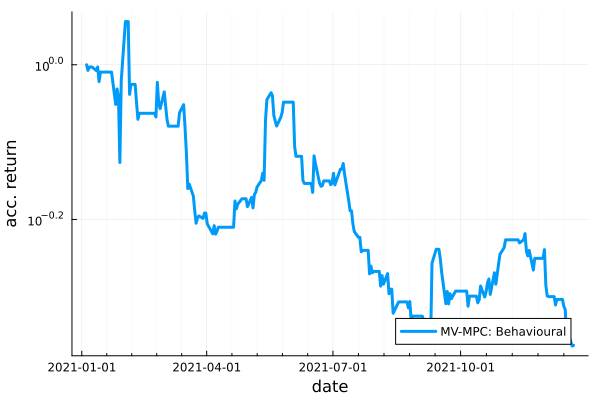

In [70]:
BH_params = merge(core_MPC_parameters,Dict(
        "pastHorizon"=>26
        ))
BH_extras = merge(core_MPC_extras,Dict())

BH_MPC_initialize!(context) = general_initialize!(context,BH_extras, BH_params; returnHistoryStartData=returnHistoryStartData_Backtest)  
BH_MPC_TL!(context, data) = MPC_tradingLogic!(context, data; forecastFun=behaviouralForecast)

BH_Backtest_Context = DEDS.run(
        data_backtest,
        BH_MPC_initialize!,
        BH_MPC_TL!,
        my_execute_orders!,
        my_expose_data;
        audit=true,
        verbose=true,
        initialEvents=deepcopy(backtestingEvents),
    )

obh_results = summarizePerformance(OHLCV_data, BH_Backtest_Context; includeAccounts=false)
BH_Backtest_Context = nothing;  GC.gc() 

obh_acc_return = obh_results.dollarValue ./obh_results.dollarValue[1]
obh_dates = obh_results.date

plotd=plot(obh_dates, obh_acc_return, label="MV-MPC: Behavioural",xlabel="date",ylabel="acc. return", linewidth=3, yscale=:log10, minorgrid=true, legend=:bottomright)
savefig(plotd,joinpath(fig_dir,"E1_02_BH_Forecast_Optimized_$(join(string.(values(BH_params)),"_")).svg"))


display(plotd)

## HMM Backtest

[ Info: Done


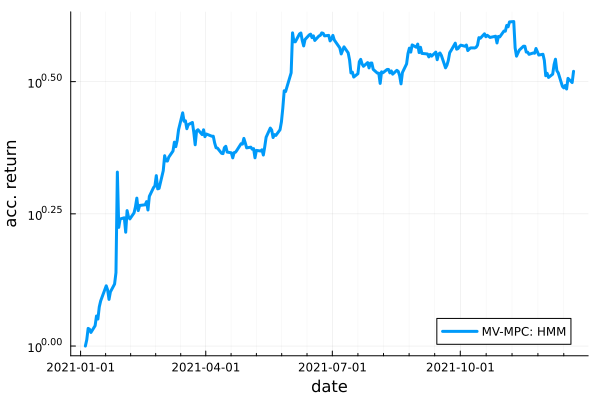

In [185]:
HMM_params = merge(core_MPC_parameters,Dict(
        "riskWeight"=>1.2,
    "recalibrationPeriod"=>500 # Index to keep track of not yet ingested data.
))
HMM_extras = merge(core_MPC_extras,Dict(
    "hmm"=>nothing, # Initial Hidden Markov Model
    "obs_seq"=>[], # Initial Warm-Start Data
    "lastScanIx"=>1, # Index to keep track of not yet ingested data.
    "excludeCurrencyFromCalculation"=>true, # Behavioural & HMM: Reduce dimensionality of problem by 1
))

HMM_MPC_initialize!(context) = general_initialize!(context,HMM_extras, HMM_params; 
    returnHistoryStartData=returnHistoryStartData_Backtest)  
HMM_MPC_TL!(context, data) = MPC_tradingLogic!(context, data; forecastFun=hmmForecast)

HMM_Backtest_Context = DEDS.run(
        data_backtest,
        HMM_MPC_initialize!,
        HMM_MPC_TL!,
        my_execute_orders!,
        my_expose_data;
        audit=true,
        verbose=true,
        initialEvents=deepcopy(backtestingEvents),
    )

@info "Done"
using Plots: plot, plot!, savefig
hmm_results = summarizePerformance(OHLCV_data, HMM_Backtest_Context; includeAccounts=false)
HMM_Backtest_Context = nothing;  GC.gc() 

hmm_acc_return = hmm_results.dollarValue ./hmm_results.dollarValue[1]
hmm_dates = hmm_results.date

plotd=plot(hmm_dates, hmm_acc_return, label="MV-MPC: HMM",xlabel="date",
    ylabel="acc. return", linewidth=3, yscale=:log10, minorgrid=true, legend=:bottomright)
     
savefig(plotd,joinpath(fig_dir,"E1_02_HMM_Forecast_$(join(string.(values(HMM_params)),"_")).svg"))
display(plotd)

## Markowitz
Implement the traditional markowitz strategy.

In [39]:
# Markowitz trading logic
using SparseArrays: sparse, I, spdiagm, SparseVector

using AirBorne.Utils: δ

using AirBorne.Markets.StaticMarket: genOrder,  place_order!, ordersForPortfolioRedistribution 
using DotMaps:DotMap
# using AirBorne.Markets.StaticMarket: Order,

function markowitz_initialize!(
    context::ContextTypeA;
    currency_symbol::String="FEX/USD",
    initialCapital::Float64=10.0^5,
    parameters::Dict=Dict(),
    otherExtras::Dict=Dict(),
    returnHistoryWarmUp::DataFrame=Dataframe()
)

    # Internal Data Storage
    context.extra.returnsHistory = DataFrame()

    # Fixed attributes & parameters
    context.extra.currency_symbol = currency_symbol
    context.extra.valueHistory = DataFrame()
    context.extra.returnHistory = returnHistoryWarmUp
    context.extra.currentValue = DataFrame()
    context.extra.pastValue = DataFrame()

    [setindex!(context.extra, otherExtras[key], key) for key in keys(otherExtras)]

    # Initialize Accounts     
    context.accounts.usd = DotMap(Dict())
    context.accounts.usd.balance = initialCapital
    context.accounts.usd.currency = currency_symbol

    # Initialize Portfolio
    if :symbolOrder in keys(context.extra)
        # push!(context.extra.symbolOrder, currency_symbol)
        [setindex!(context.portfolio, 0.0, n) for n in context.extra.symbolOrder] # Initialize an empty portfolio
    end
    context.portfolio[currency_symbol] = initialCapital # Sync portfolio with account at first

    # Adjustable hyper-parameters by StrategyOptimization
    [setindex!(context.parameters, parameters[key], key) for key in keys(parameters)]

    return nothing
end

function markowitz_trading_logic!(context, data)
    
    #######################
    ####  Update data  ####
    #######################
    if size(data, 1) == 0 # No New data, nothing to do
        return nothing
    end
    context.extra.pastValue = context.extra.currentValue
    context.extra.currentValue = stockValuation(data)
    [push!(context.extra.valueHistory, r) for r in eachrow(context.extra.currentValue)]

    if size(context.extra.pastValue, 1) > 0 # Add new data to history record
        r1 = returns(vcat(context.extra.pastValue, context.extra.currentValue))
        push!(context.extra.returnHistory, r1[end, :])
    end
    # Other parameters from context
    assetPricing = context.extra.currentValue[1, "stockValue"]
    assetPricing[context.extra.currency_symbol] = 1.0
    𝛾_trade = get(context.parameters, "propCost", 0.05)
    min_growth = c_get(context,"min_growth",0)
    symbolOrder = context.extra.symbolOrder
    n_assets = length(symbolOrder)
    currency_symbol = context.extra.currency_symbol
    ################################
    ####  Calculate Statistics  ####
    ################################
    if size(context.extra.returnHistory, 1) < c_get(context,"sampleSize",7)
        return nothing # Not enough history data to 
    end
    d = deepcopy(context.extra.returnHistory[(end - c_get(context,"sampleSize",7) + 1):end, symbolOrder]) # sample
    # d[!,currency_symbol].=0 # Add currency
    M = covariance(d[!, symbolOrder]) # Covariance Matrix
    m = mean(Matrix(d[!, symbolOrder]); dims=1) # mean
    max_return, ix = findmax(m) # Maximum expected return

    ######################################
    ####  Solve Optimization problem  ####
    ######################################
    if max_return > min_growth # Feasible problem
        if context.extra.idealPortfolioDistribution == []
            initial_point = zeros(size(m))
            initial_point[ix] = 1.0
        else
            initial_point = context.extra.idealPortfolioDistribution
        end

        model = Model(Ipopt.Optimizer)
        set_silent(model)
        @variable(model, x[1:length(m)] >= 0) # Positive definite
        @constraint(model, sum(x)==1) # Sum of portfolio distribution equals 1
        @constraint(model, sum([m[i]*x[i] for i=1:n_assets]) - min_growth>=0) # Sum of portfolio distribution equals 1
        @objective(model, Min, x' * M * x)
        
        optimize!(model)
        sol = round.(value.(x); digits=3)
        context.extra.idealPortfolioDistribution = isnothing(sol) ? zeros(size(m)) : sol
    else
        context.extra.idealPortfolioDistribution = zeros(size(m)) # Sell absolutely everytihng. Market is going down.
    end
    current_portfolio = deepcopy(convert(Dict{String,Float64}, context.portfolio))
    
    target_distribution = Dict([symbolOrder[i] => context.extra.idealPortfolioDistribution[i] for i=1:n_assets])
    
    orders = ordersForPortfolioRedistribution(
        current_portfolio,
        target_distribution,
        assetPricing;
        account=context.accounts.usd,
        curency_symbol=context.extra.currency_symbol,
        costPropFactor=𝛾_trade,
        )
    context.activeOrders =[]
    [place_order!(context, order) for order in orders] # Place orders
    
    return nothing
end


markowitz_trading_logic! (generic function with 1 method)

[ Info: Done


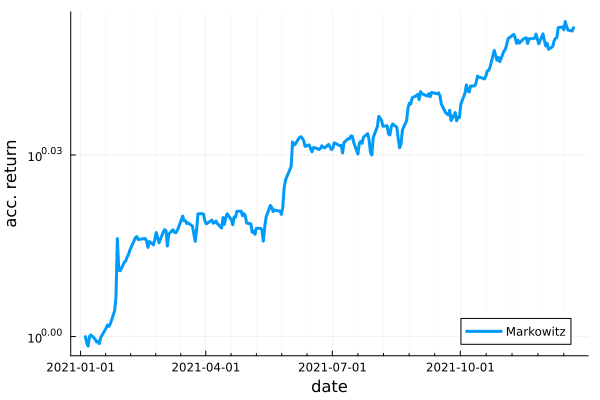

In [41]:
import AirBorne.Engines.DEDS as DEDS

markowitz_params = Dict(
    "min_growth"=>0.001,
    "sampleSize"=>20,
)

MK_extras=Dict(
    "symbolOrder"=>deepcopy(tradedAssets_w_currency),
    "propCost"=>0.02,
    "idealPortfolioDistribution"=>[],
)

my_markowitz_initialize!(context) = markowitz_initialize!(context; currency_symbol=account_currency, 
    otherExtras=MK_extras,parameters=markowitz_params,
    returnHistoryWarmUp=returnHistoryStartData_Backtest)



mk_context = DEDS.run(
    data_backtest_w_currency,
    my_markowitz_initialize!,
    markowitz_trading_logic!,
    my_execute_orders!,
    my_expose_data;
    audit=true,    
    # max_iter=35, # Run for 100 business days
    verbose=true,
    initialEvents=deepcopy(backtestingEvents),
)
@info "Done"

mk_results = summarizePerformance(OHLCV_data, mk_context; includeAccounts=false)
mk_context = nothing;  GC.gc() 

mk_acc_return = mk_results.dollarValue ./mk_results.dollarValue[1]
mk_dates = mk_results.date

plotd=plot(mk_dates, mk_acc_return, label="Markowitz",
    xlabel="date",ylabel="acc. return", linewidth=3, yscale=:log10, minorgrid=true, legend=:bottomright)

savefig(plotd,joinpath(fig_dir,"E1_02_Markowitz_$(join(string.(values(markowitz_params)),"_")).svg"))
display(plotd)


## SMA
Split the portfolio on those assets that are under a bullish signal, as long as the short term expected return is greater than 1.

In [48]:
using DataFrames: groupby, combine
function sma_initialize!(
    context::ContextTypeA;
    currency_symbol::String="FEX/USD",
    initialCapital::Float64=10.0^5,
    parameters::Dict=Dict(),
    otherExtras::Dict=Dict(),
    pastDataWarmUp::DataFrame=Dataframe()
)

    # Internal Data Storage
    context.extra.returnsHistory = DataFrame()

    # Fixed attributes & parameters
    context.extra.currency_symbol = currency_symbol
    context.extra.valueHistory = DataFrame()
    context.extra.pastData = pastDataWarmUp
    context.extra.currentValue = DataFrame()
    context.extra.pastValue = DataFrame()

    [setindex!(context.extra, otherExtras[key], key) for key in keys(otherExtras)]

    # Initialize Accounts     
    context.accounts.usd = DotMap(Dict())
    context.accounts.usd.balance = initialCapital
    context.accounts.usd.currency = currency_symbol

    # Initialize Portfolio
    if :symbolOrder in keys(context.extra)
        # push!(context.extra.symbolOrder, currency_symbol)
        [setindex!(context.portfolio, 0.0, n) for n in context.extra.symbolOrder] # Initialize an empty portfolio
    end
    context.portfolio[currency_symbol] = initialCapital # Sync portfolio with account at first

    # Adjustable hyper-parameters by StrategyOptimization
    [setindex!(context.parameters, parameters[key], key) for key in keys(parameters)]

    return nothing
end

function sma_trading_logic!(context, data)
    ####  Update data 
    if size(data, 1) == 0 # No New data, nothing to do
        return nothing
    end
    append!(context.extra.pastData, data)
    context.extra.currentValue = stockValuation(data)
    assetPricing = context.extra.currentValue[1, "stockValue"]
    assetPricing[context.extra.currency_symbol] = 1.0
    
    # Parameters definitions
    𝛾_trade = get(context.parameters, "propCost", 0.05)
    short_horizon = c_get(context,"short_horizon",20)
    long_horizon = c_get(context,"long_horizon",60)
    symbolOrder = context.extra.symbolOrder
    n_assets = length(symbolOrder)
    currency_symbol = context.extra.currency_symbol
    
    shortSMA(sdf_col) = mean(last(sdf_col, short_horizon))
    longSMA(sdf_col) = mean(last(sdf_col, long_horizon))
    buySignal(sdf_col) = shortSMA(sdf_col) > longSMA(sdf_col)
    
    ####  Core SMA Logic
    if size(context.extra.pastData, 1) < long_horizon
        return nothing # Not enough history data to 
    end
    
    sma_df = combine(
        groupby(context.extra.pastData, ["assetID"]),
        :close => shortSMA => :SMA_S,
        :close => longSMA => :SMA_L,
        :close => buySignal => :buy,
    )
    buy_fun(assetID) = assetID in sma_df[sma_df.buy,"assetID"] ? 1.0/length(sma_df[sma_df.buy,"assetID"]) : 0.0
    
    # Produce orders
    target_distribution = Dict([x=>buy_fun(x) for x=symbolOrder])
    current_portfolio = deepcopy(convert(Dict{String,Float64}, context.portfolio))
    orders = ordersForPortfolioRedistribution(
        current_portfolio,
        target_distribution,
        assetPricing;
        account=context.accounts.usd,
        curency_symbol=context.extra.currency_symbol,
        costPropFactor=𝛾_trade,
        )
    context.activeOrders =[]
    [place_order!(context, order) for order in orders] # Place orders
    
    return nothing
end

sma_trading_logic! (generic function with 1 method)

[ Info: Done


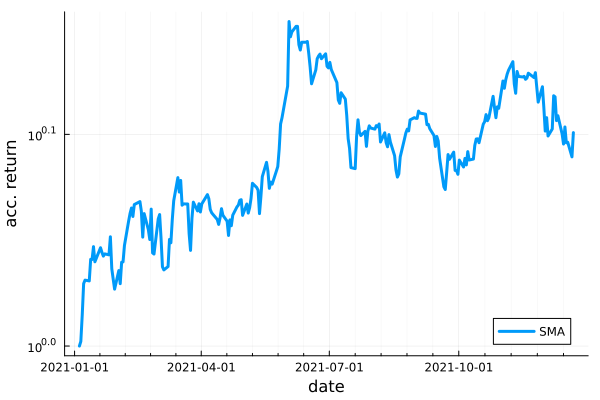

In [49]:
import AirBorne.Engines.DEDS as DEDS
sma_params = Dict(
    "short_horizon"=>20,
    "long_horizon"=>60,
)

sma_extras=Dict(
    "symbolOrder"=>deepcopy(tradedAssets_wo_currency),
    "propCost"=>0.02,
    "idealPortfolioDistribution"=>[],
)


my_sma_initialize!(context) = sma_initialize!(context; currency_symbol=account_currency, 
    otherExtras=sma_extras,parameters=sma_params,
    pastDataWarmUp=warmUpData_backtest)
my_sma_expose_data(context,data) = expose_data(context,data; historical=false)


sma_context = DEDS.run(
    data_backtest_wo_currency,
    my_sma_initialize!,
    sma_trading_logic!,
    my_execute_orders!, # Compatible with SMA
    my_expose_data; # Compatible with SMA
    audit=true,    
    verbose=true,
    initialEvents=deepcopy(backtestingEvents),
)
@info "Done"
sma_results = summarizePerformance(OHLCV_data, sma_context; includeAccounts=false)
sma_context = nothing;  GC.gc() 

sma_acc_return = sma_results.dollarValue ./sma_results.dollarValue[1]
sma_dates = sma_results.date

plotd=plot(sma_dates, sma_acc_return, label="SMA",
    xlabel="date",ylabel="acc. return", linewidth=3, yscale=:log10, minorgrid=true, legend=:bottomright)

fig_dir = joinpath(@__DIR__, "figures")
savefig(plotd,joinpath(fig_dir,"E1_02_SMA_$(join(string.(values(sma_params)),"_")).svg"))
display(plotd)


## Best static asset & distributed investment
As a benchmark we will compare the performance of the Mean Variance MPC with the performance of the asset with most growth as well as the average one. 

[ Info: [4, 20, 6, 9, 2, 23, 16, 5, 24, 13, 3, 17, 14, 7, 10, 27, 8, 26, 18, 19, 15, 22, 1, 12, 21, 25, 11]
[ Info: [0.8119657870017315, 1.5061748198094873, 1.2860626810735796, 15.074626579576433, 1.336759142244076, 2.2171808607872667, 1.0846153987229934, 0.985055198779743, 1.6616877841303042, 1.0204946741165741, 0.40601503759398494, 0.7007575930898108, 1.2902590439307706, 1.1421446447301487, 0.8896321328918044, 1.3717251916918418, 1.1548672096467951, 0.9019417271671161, 0.9002176168113255, 2.5610665544093987, 0.6967418458007826, 0.8529526121828587, 1.3883075534652047, 1.3327571722574898, 0.497427832287208, 0.9640560391758581, 1.0]


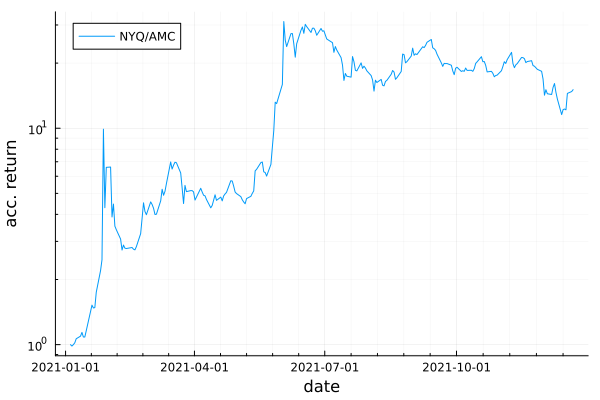

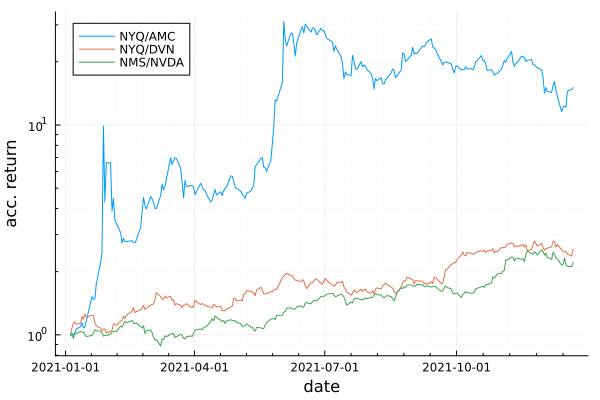

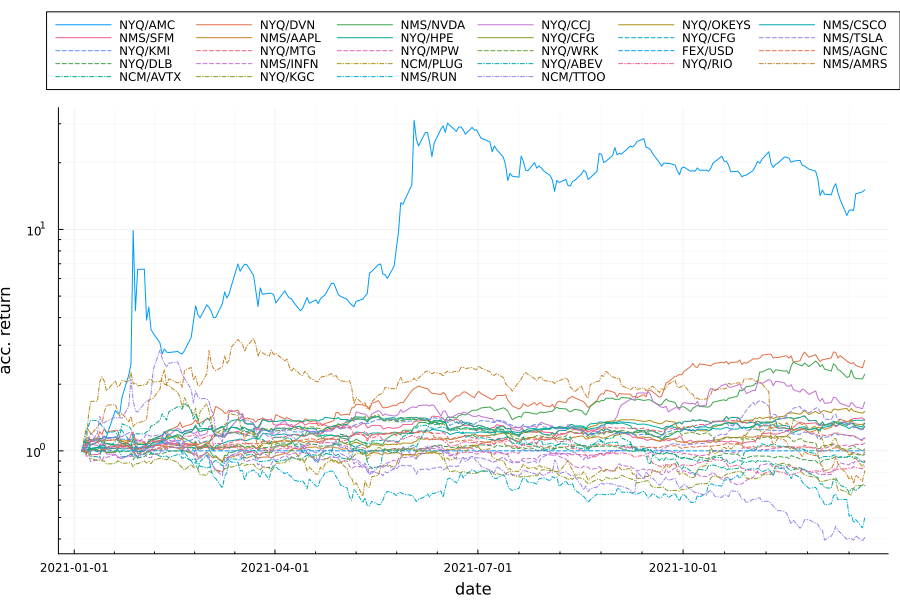

In [63]:
using Plots: plot, savefig
tradedAssets1 = deepcopy(unique(data.assetID))
tradedAssets_w_currency = deepcopy(tradedAssets1)
push!(tradedAssets_w_currency,"FEX/USD")
lw = 1
backtest_stockValuesMat = Matrix(sv[[ d in [x.date for x in backtestingEvents] for d=sv.date],tradedAssets_w_currency])
backtest_stockReturnsMat = backtest_stockValuesMat./backtest_stockValuesMat[1,:]'
# best_single_return, ix = findmax(backtest_stockReturnsMat[end,:])
rank_ixs = sortperm(backtest_stockReturnsMat[end,:], rev=true)
@info rank_ixs
@info backtest_stockReturnsMat[end,:]
ix = rank_ixs[1]
d= [x.date for x in backtestingEvents] 
single_stock_dates = [x.date for x in backtestingEvents]

plotd=plot(single_stock_dates, backtest_stockReturnsMat[:,ix], label="$(tradedAssets_w_currency[ix])",
    xlabel="date",ylabel="acc. return", linewidth=lw, yscale=:log10, minorgrid=true, legend=:topleft)

fig_dir = joinpath(@__DIR__, "figures")
savefig(plotd,joinpath(fig_dir,"E1_02_best_static_asset_return_top_1.svg"))
display(plotd)

for i=2:3
    ix = rank_ixs[i]
    plot!(single_stock_dates, backtest_stockReturnsMat[:,ix], label="$(tradedAssets_w_currency[ix])", linewidth=lw)
end
fig_dir = joinpath(@__DIR__, "figures")
savefig(plotd,joinpath(fig_dir,"E1_02_best_static_asset_return_top_3.svg"))
display(plotd)

for i=4:10
    ix = rank_ixs[i]
    plot!(single_stock_dates, backtest_stockReturnsMat[:,ix], label="$(tradedAssets_w_currency[ix])",
        linewidth=lw,legend_columns=6,legend = :outertop, size = (900, 600))
end

for i=10:19
    ix = rank_ixs[i]
    plot!(single_stock_dates, backtest_stockReturnsMat[:,ix], label="$(tradedAssets_w_currency[ix])",
        line=:dash, linewidth=lw,legend_columns=6,legend = :outertop, size = (900, 600))
end

for i=20:length(p)
    ix = rank_ixs[i]
    plot!(single_stock_dates, backtest_stockReturnsMat[:,ix], label="$(tradedAssets_w_currency[ix])",
        line=:dashdot, linewidth=lw,legend_columns=6,legend = :outertop, size = (900, 600))
end

fig_dir = joinpath(@__DIR__, "figures")
savefig(plotd,joinpath(fig_dir,"E1_02_best_static_asset_return_all.svg"))
display(plotd)

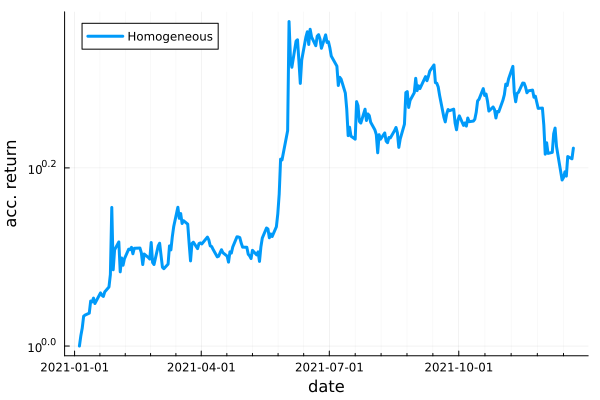

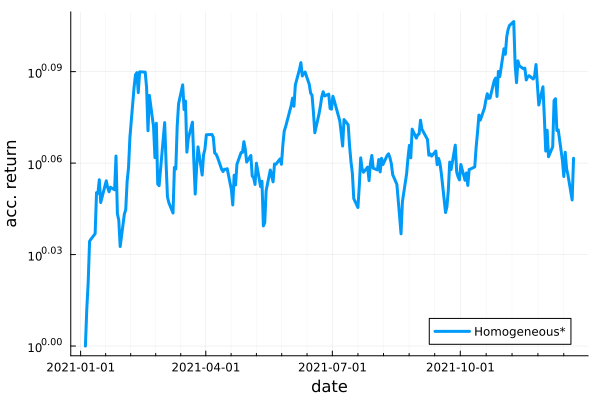

In [56]:
homogeneous_dates = [x.date for x in backtestingEvents]
homogeneous_returns = sum(backtest_stockReturnsMat,dims=2)./size(backtest_stockReturnsMat,2)
homogeneous_returns_wo_best = sum(backtest_stockReturnsMat[:,1:end .!= rank_ixs[1]],dims=2)./(size(backtest_stockReturnsMat,2)-1)

plotd=plot(homogeneous_dates, homogeneous_returns , label="Homogeneous",xlabel="date",ylabel="acc. return", linewidth=3, yscale=:log10, minorgrid=true)
savefig(plotd,joinpath(fig_dir,"E1_02_homogeneous_distribution.svg"))
display(plotd)

plotd=plot(homogeneous_dates,homogeneous_returns_wo_best , label="Homogeneous*",xlabel="date",ylabel="acc. return", linewidth=3, yscale=:log10, minorgrid=true)
savefig(plotd,joinpath(fig_dir,"E1_02_homogeneous_distribution_wo_AMC.svg"))
display(plotd)


## Combined figures

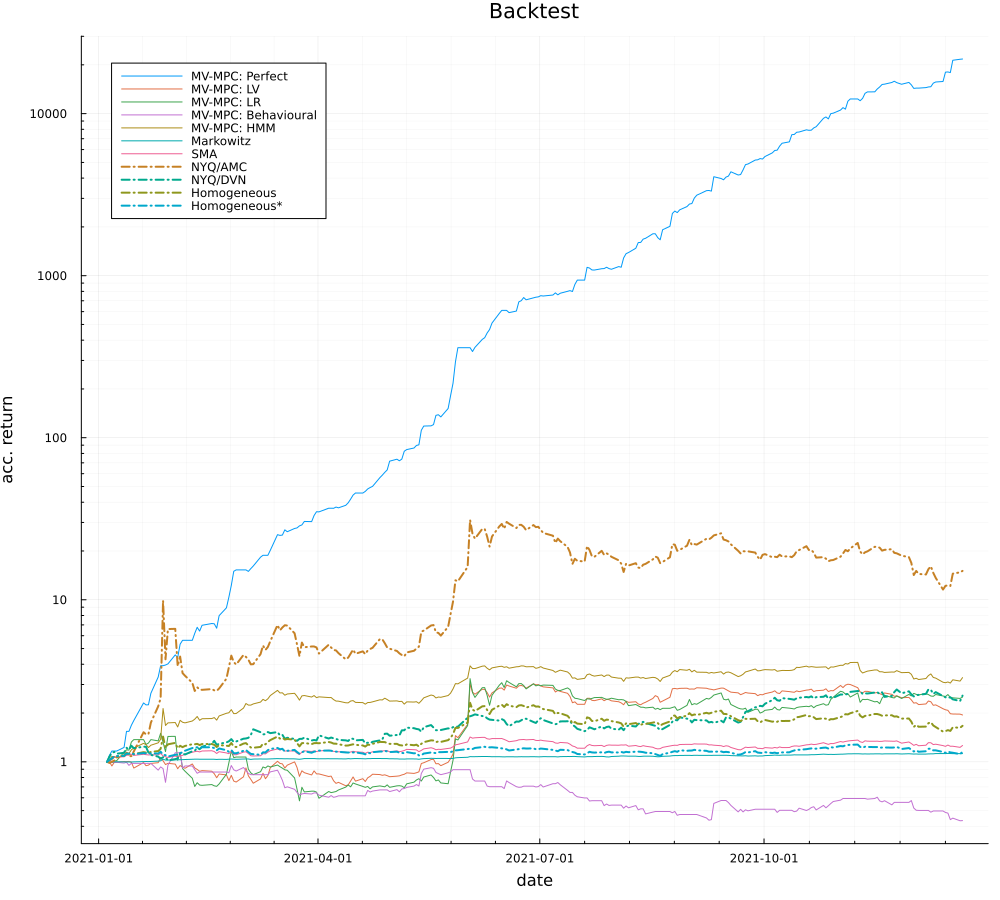

In [194]:


plotd=plot(title="Backtest")
plot!(pf_dates, pf_acc_return, label="MV-MPC: Perfect")
plot!(lv_dates, lv_acc_return, label="MV-MPC: LV")
plot!(olr_dates, olr_acc_return, label="MV-MPC: LR")
# plot!(bh_dates, bh_acc_return, label="MV-MPC: Behavioural")
plot!(obh_dates, obh_acc_return, label="MV-MPC: Behavioural")
plot!(hmm_dates, hmm_acc_return, label="MV-MPC: HMM")
plot!(mk_dates, mk_acc_return, label="Markowitz")
plot!(sma_dates, sma_acc_return, label="SMA")
plot!(single_stock_dates,backtest_stockReturnsMat[:,rank_ixs[1]],label="$(tradedAssets_w_currency[rank_ixs[1]])",line=:dashdot, lw=2)
plot!(single_stock_dates,backtest_stockReturnsMat[:,rank_ixs[2]],label="$(tradedAssets_w_currency[rank_ixs[2]])",line=:dashdot, lw=2)
plot!(homogeneous_dates, homogeneous_returns , label="Homogeneous",line=:dashdot, lw=2)#, marker=:square, markeralpha=0.1)
plot!(homogeneous_dates,homogeneous_returns_wo_best , label="Homogeneous*",line=:dashdot, lw=2)#, marker=:square, markeralpha=0.1)
# plot!()
# plot!()
# plot!(xlabel="date",ylabel="acc. return",linewidth=3, yscale=:log10, minorgrid=true, legend=:topleft, yformatter=yformatter)
# plot!(xlabel="date",ylabel="acc. return",linewidth=3, yscale=:log10, minorgrid=true, legend=:outerright, yformatter=yformatter, size = (1000, 900))
plot!(xlabel="date",ylabel="acc. return",linewidth=3, yscale=:log10, minorgrid=true, legend=:topleft, yformatter=yformatter, size = (1000, 900))

savefig(plotd,joinpath(fig_dir,"E1_02_all_comparison.svg"))
display(plotd)

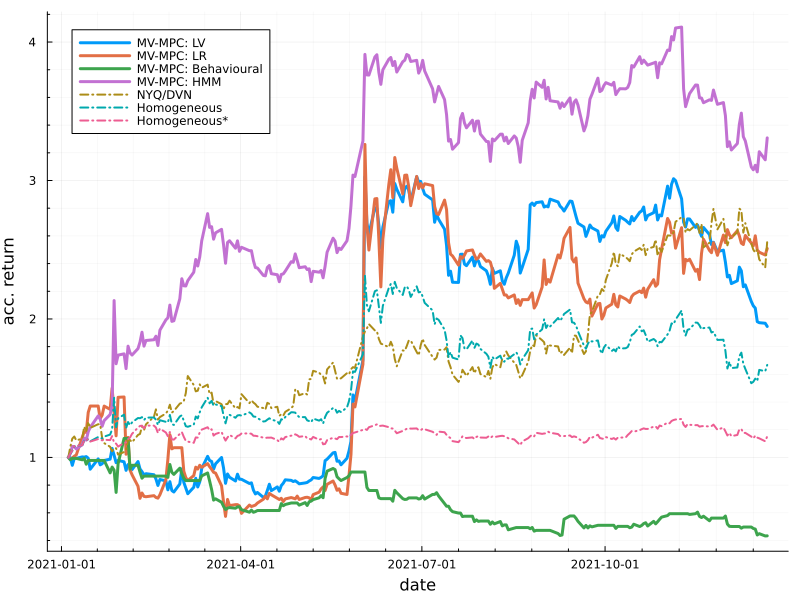

In [201]:
# Forecasting methods comparison

# plotd=plot(title="Backtest")
plotd=plot()

plot!(lv_dates, lv_acc_return,  lw=3, label="MV-MPC: LV")
plot!(olr_dates, olr_acc_return,lw=3, label="MV-MPC: LR")
# plot!(bh_dates, bh_acc_return,lw=3, label="MV-MPC: Behavioural")
plot!(obh_dates, obh_acc_return,lw=3, label="MV-MPC: Behavioural")
plot!(hmm_dates, hmm_acc_return,lw=3, label="MV-MPC: HMM")
# plot!(mk_dates, mk_acc_return,lw=3, label="Markowitz")
# plot!(sma_dates, sma_acc_return, label="SMA")
plot!(single_stock_dates,backtest_stockReturnsMat[:,rank_ixs[2]],label="$(tradedAssets_w_currency[rank_ixs[2]])",line=:dashdot, lw=2)
plot!(homogeneous_dates, homogeneous_returns , label="Homogeneous",line=:dashdot, lw=2)#, marker=:square, markeralpha=0.1)
plot!(homogeneous_dates,homogeneous_returns_wo_best , label="Homogeneous*",line=:dashdot, lw=2)#, marker=:square, markeralpha=0.1)
# plot!()
# plot!()
# plot!(xlabel="date",ylabel="acc. return",linewidth=3, yscale=:log10, minorgrid=true, legend=:topleft, yformatter=yformatter)
# plot!(xlabel="date",ylabel="acc. return",linewidth=3, yscale=:log10, minorgrid=true, legend=:outerright, yformatter=yformatter, size = (1000, 900))
plot!(xlabel="date",ylabel="acc. return",linewidth=3,  minorgrid=true, legend=:topleft, size = (800, 600))
# yscale=:log10, yformatter=yformatter, 
savefig(plotd,joinpath(fig_dir,"E1_02_MVMPC_comparison.svg"))
display(plotd)

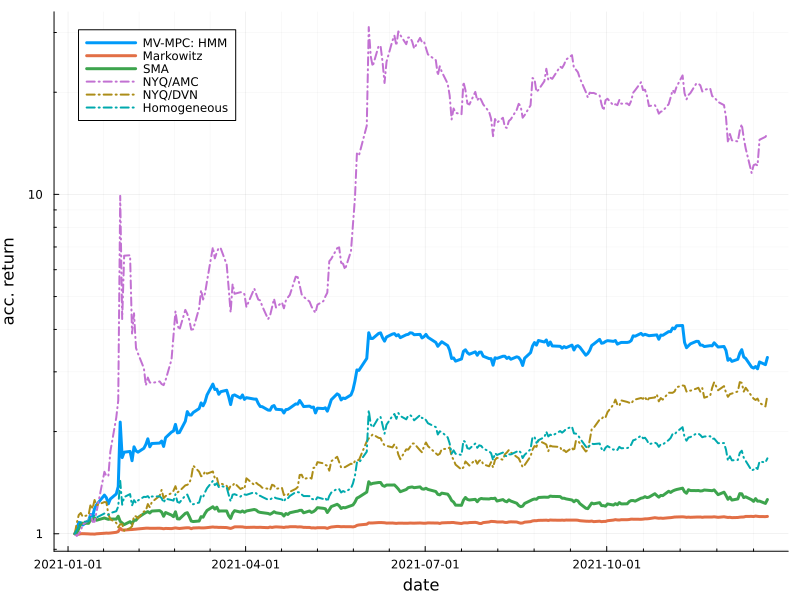

In [200]:
# Forecasting methods comparison

# plotd=plot(title="Backtest")
plotd=plot()

# plot!(lv_dates, lv_acc_return,  lw=3, label="MV-MPC: LV")
# plot!(olr_dates, olr_acc_return,lw=3, label="MV-MPC: LR")
# # plot!(bh_dates, bh_acc_return,lw=3, label="MV-MPC: Behavioural")
# plot!(obh_dates, obh_acc_return,lw=3, label="MV-MPC: Behavioural")
plot!(hmm_dates, hmm_acc_return,lw=3, label="MV-MPC: HMM")
plot!(mk_dates, mk_acc_return, lw=3, label="Markowitz")
plot!(sma_dates, sma_acc_return,lw=3, label="SMA")
plot!(single_stock_dates,backtest_stockReturnsMat[:,rank_ixs[1]],label="$(tradedAssets_w_currency[rank_ixs[1]])",line=:dashdot, lw=2)
plot!(single_stock_dates,backtest_stockReturnsMat[:,rank_ixs[2]],label="$(tradedAssets_w_currency[rank_ixs[2]])",line=:dashdot, lw=2)
plot!(homogeneous_dates, homogeneous_returns , label="Homogeneous",line=:dashdot, lw=2)#, marker=:square, markeralpha=0.1)
# plot!(homogeneous_dates,homogeneous_returns_wo_best , label="Homogeneous*",line=:dashdot, lw=2)#, marker=:square, markeralpha=0.1)
# plot!()
# plot!()
# plot!(xlabel="date",ylabel="acc. return",linewidth=3, yscale=:log10, minorgrid=true, legend=:topleft, yformatter=yformatter)
# plot!(xlabel="date",ylabel="acc. return",linewidth=3, yscale=:log10, minorgrid=true, legend=:outerright, yformatter=yformatter, size = (1000, 900))
plot!(xlabel="date",ylabel="acc. return",linewidth=3,  minorgrid=true, legend=:topleft, size = (800, 600),
yscale=:log10, yformatter=yformatter, 
    )
savefig(plotd,joinpath(fig_dir,"E1_02_strategies_comparison.svg"))
display(plotd)

## Data Management & Garbage collection

In [183]:
# Clear memory
# Each context with audit, is between approx 1~2 Gb
# Once contexts are no longer needed is advisable to delete it. (or not audit it if possible) 
LV_Backtest_Context = nothing; # GC.gc() 
PF_Backtest_Context = nothing; # GC.gc() 
LR_Backtest_Context = nothing; # GC.gc() 
BH_Backtest_Context = nothing; # GC.gc() 
HMM_Backtest_Context = nothing; # GC.gc() 
training_ref_context = nothing;
validation_ref_context = nothing;
mk_context = nothing;
sma_context = nothing;
# No significant RAM changes regarding results clearing
pf_results = nothing;  #GC.gc() 
lv_results = nothing;  #GC.gc() 
olr_results = nothing;  #GC.gc() 
bh_results = nothing;  #GC.gc() 
obh_results = nothing;  #GC.gc() 
GC.gc() # Garbage collection

In [189]:
a = varinfo(sortby=:size)


| name                              |        size | summary                                                      |
|:--------------------------------- | -----------:|:------------------------------------------------------------ |
| Base                              |             | Module                                                       |
| Core                              |             | Module                                                       |
| Main                              |             | Module                                                       |
| returnHistoryStartData_Backtest   |  18.761 MiB | 10092×29 DataFrame                                           |
| returnHistoryWarmUp               |   8.928 MiB | 4802×29 DataFrame                                            |
| OHLCV_data                        |   3.114 MiB | 33993×12 DataFrame                                           |
| data                              |   3.000 MiB | 32734×12 DataFrame                                           |
| warmUpData_backtest               |   2.400 MiB | 26182×12 DataFrame                                           |
| sr                                |   2.343 MiB | 1259×29 DataFrame                                            |
| sv                                |   2.324 MiB | 1259×29 DataFrame                                            |
| data_training                     |   1.805 MiB | 19682×12 DataFrame                                           |
| returnHistoryStartData_Validation |   1.404 MiB | 754×29 DataFrame                                             |
| data_validation                   |   1.205 MiB | 13130×12 DataFrame                                           |
| sma_results                       |   1.066 MiB | 246×10 DataFrame                                             |
| mk_results                        |   1.060 MiB | 246×10 DataFrame                                             |
| hmm_results                       |   1.046 MiB | 246×10 DataFrame                                             |
| olr_results                       |   1.041 MiB | 246×10 DataFrame                                             |
| data_backtest_w_currency          | 640.205 KiB | 6804×12 DataFrame                                            |
| data_backtest                     | 617.041 KiB | 6552×12 DataFrame                                            |
| data_backtest_wo_currency         | 617.041 KiB | 6552×12 DataFrame                                            |
| val_μFcastMat                     | 372.141 KiB | 27×7×252 Array{Float64, 3}                                   |
| train_μFcastMat                   | 370.664 KiB | 27×7×251 Array{Float64, 3}                                   |
| usdData                           | 120.141 KiB | 1259×12 DataFrame                                            |
| backtest_stockValuesMat           |  58.179 KiB | 245×27 Matrix{Union{Missing, Float64}}                       |
| backtest_stockReturnsMat          |  51.719 KiB | 245×27 Matrix{Float64}                                       |
| plotd                             |  40.932 KiB | Plots.Plot{Plots.GRBackend}                                  |
| allEvents                         |  39.403 KiB | 1259-element Vector{TimeEvent}                               |
| a                                 |  18.441 KiB | Markdown.MD                                                  |
| validationEvents                  |   7.966 KiB | 253-element Vector{TimeEvent}                                |
| trainingEvents                    |   7.935 KiB | 252-element Vector{TimeEvent}                                |
| backtestingEvents                 |   7.716 KiB | 245-element Vector{TimeEvent}                                |
| bh_acc_return                     |   1.961 KiB | 246-element Vector{Float64}                                  |
| bh_dates                          |   1.961 KiB | 246-element Vector{DateTime}                                 |
| hmm_acc_return                    |   1.961 KiB | 246-element Vector{Float64}                                  |
| hmm_dates                         |   1.961 KiB | 246-element Vector{DateTime}                                 |
| lv_acc_return                     |   1.961 KiB | 246-element Vector{Float64}                                  |
| lv_dates                          |   1.961 KiB | 246-element Vector{DateTime}                                 |
| mk_acc_return                     |   1.961 KiB | 246-element Vector{Float64}                                  |
| mk_dates                          |   1.961 KiB | 246-element Vector{DateTime}                                 |
| obh_acc_return                    |   1.961 KiB | 246-element Vector{Float64}                                  |
| obh_dates                         |   1.961 KiB | 246-element Vector{DateTime}                                 |
| olr_acc_return                    |   1.961 KiB | 246-element Vector{Float64}                                  |
| olr_dates                         |   1.961 KiB | 246-element Vector{DateTime}                                 |
| pf_acc_return                     |   1.961 KiB | 246-element Vector{Float64}                                  |
| pf_dates                          |   1.961 KiB | 246-element Vector{DateTime}                                 |
| sma_acc_return                    |   1.961 KiB | 246-element Vector{Float64}                                  |
| sma_dates                         |   1.961 KiB | 246-element Vector{DateTime}                                 |
| d                                 |   1.953 KiB | 245-element Vector{DateTime}                                 |
| homogeneous_dates                 |   1.953 KiB | 245-element Vector{DateTime}                                 |
| homogeneous_returns               |   1.953 KiB | 245×1 Matrix{Float64}                                        |
| homogeneous_returns_wo_best       |   1.953 KiB | 245×1 Matrix{Float64}                                        |
| single_stock_dates                |   1.953 KiB | 245-element Vector{DateTime}                                 |
| BH_extra                          |   1.393 KiB | Dict{String, Any} with 8 entries                             |
| HMM_extra                         |   1.393 KiB | Dict{String, Any} with 8 entries                             |
| HMM_extras                        |   1.351 KiB | Dict{String, Any} with 8 entries                             |
| BH_extras                         |   1.324 KiB | Dict{Any, Any} with 4 entries                                |
| LV_extras                         |   1.324 KiB | Dict{Any, Any} with 4 entries                                |
| LR_extra                          |   1.316 KiB | Dict{String, Any} with 6 entries                             |
| LV_extra                          |   1.297 KiB | Dict{String, Any} with 5 entries                             |
| LR_extras                         |   1.261 KiB | Dict{String, Any} with 4 entries                             |
| ref_extras                        |   1.241 KiB | Dict{String, Any} with 4 entries                             |
| core_MPC_extras                   |   1.223 KiB | Dict{String, Any} with 4 entries                             |
| MK_extras                         |   1.218 KiB | Dict{String, Any} with 3 entries                             |
| PF_extras                         |   1.199 KiB | Dict{String, Any} with 4 entries                             |
| sma_extras                        |   1.195 KiB | Dict{String, Any} with 3 entries                             |
| traded_assets                     |   682 bytes | 28-element Vector{String}                                    |
| tradedAssets_w_currency           |   674 bytes | 27-element Vector{String}                                    |
| tradedAssets1                     |   651 bytes | 26-element Vector{String}                                    |
| tradedAssets_wo_currency          |   651 bytes | 26-element Vector{String}                                    |
| feeStructure                      |   595 bytes | 1-element Vector{Dict}                                       |
| LV_params                         |   556 bytes | Dict{Any, Any} with 3 entries                                |
| LR_params                         |   551 bytes | Dict{String, Int64} with 4 entries                           |
| HMM_params                        |   517 bytes | Dict{Any, Any} with 2 entries                                |
| markowitz_params                  |   508 bytes | Dict{String, Real} with 2 entries                            |
| LR_param                          |   507 bytes | Dict{String, Int64} with 2 entries                           |
| sma_params                        |   497 bytes | Dict{String, Int64} with 2 entries                           |
| LV_param                          |   488 bytes | Dict{String, Int64} with 1 entry                             |
| BH_params                         |   483 bytes | Dict{Any, Any} with 1 entry                                  |
| HMM_param                         |   483 bytes | Dict{String, Int64} with 1 entry                             |
| BH_param                          |   475 bytes | Dict{String, Int64} with 1 entry                             |
| PF_params                         |   456 bytes | Dict{Any, Any} with 0 entries                                |
| core_MPC_parameters               |   456 bytes | Dict{Any, Any} with 0 entries                                |
| ref_params                        |   456 bytes | Dict{Any, Any} with 0 entries                                |
| p                                 |   256 bytes | 27-element Vector{Int64}                                     |
| rank_ixs                          |   256 bytes | 27-element Vector{Int64}                                     |
| BH_vs_days                        |    96 bytes | 7-element Vector{Float64}                                    |
| HMM_vs_days                       |    96 bytes | 7-element Vector{Float64}                                    |
| LR_vs_days                        |    96 bytes | 7-element Vector{Float64}                                    |
| LV_vs_days                        |    96 bytes | 7-element Vector{Float64}                                    |
| cache_dir                         |    82 bytes | 74-codeunit String                                           |
| fig_dir                           |    79 bytes | 71-codeunit String                                           |
| backtest_years                    |    48 bytes | 1-element Vector{Int64}                                      |
| training_years                    |    48 bytes | 1-element Vector{Int64}                                      |
| validation_years                  |    48 bytes | 1-element Vector{Int64}                                      |
| rscope                            |    16 bytes | 8-codeunit String                                            |
| account_currency                  |    15 bytes | 7-codeunit String                                            |
| dollar_symbol                     |    15 bytes | 7-codeunit String                                            |
| bundle_id                         |    13 bytes | 5-codeunit String                                            |
| futureHorizon                     |     8 bytes | Int64                                                        |
| ix                                |     8 bytes | Int64                                                        |
| lw                                |     8 bytes | Int64                                                        |
| maxSimIter                        |     8 bytes | Int64                                                        |
| BH_Backtest_Context               |     0 bytes | Nothing                                                      |
| BH_MPC_TL!                        |     0 bytes | BH_MPC_TL! (generic function with 1 method)                  |
| BH_MPC_initialize!                |     0 bytes | BH_MPC_initialize! (generic function with 1 method)          |
| HMM_Backtest_Context              |     0 bytes | Nothing                                                      |
| HMM_MPC_TL!                       |     0 bytes | HMM_MPC_TL! (generic function with 1 method)                 |
| HMM_MPC_initialize!               |     0 bytes | HMM_MPC_initialize! (generic function with 1 method)         |
| LR_Backtest_Context               |     0 bytes | Nothing                                                      |
| LR_Forecast                       |     0 bytes | LR_Forecast (generic function with 1 method)                 |
| LR_MPC_TL!                        |     0 bytes | LR_MPC_TL! (generic function with 1 method)                  |
| LR_MPC_initialize!                |     0 bytes | LR_MPC_initialize! (generic function with 1 method)          |
| LV_Backtest_Context               |     0 bytes | Nothing                                                      |
| LV_Forecast                       |     0 bytes | LV_Forecast (generic function with 1 method)                 |
| LV_MPC_TL!                        |     0 bytes | LV_MPC_TL! (generic function with 1 method)                  |
| LV_MPC_initialize!                |     0 bytes | LV_MPC_initialize! (generic function with 1 method)          |
| MPC_tradingLogic!                 |     0 bytes | MPC_tradingLogic! (generic function with 1 method)           |
| PF_Backtest_Context               |     0 bytes | Nothing                                                      |
| PF_forecastFun                    |     0 bytes | PF_forecastFun (generic function with 1 method)              |
| Ref_initialize!                   |     0 bytes | Ref_initialize! (generic function with 1 method)             |
| behaviouralForecast               |     0 bytes | behaviouralForecast (generic function with 1 method)         |
| bh_results                        |     0 bytes | Nothing                                                      |
| fitHMM                            |     0 bytes | fitHMM (generic function with 1 method)                      |
| forcastTradingLogic!              |     0 bytes | forcastTradingLogic! (generic function with 1 method)        |
| gen_hmm                           |     0 bytes | gen_hmm (generic function with 1 method)                     |
| general_initialize!               |     0 bytes | general_initialize! (generic function with 1 method)         |
| generic_profit_obj                |     0 bytes | generic_profit_obj (generic function with 1 method)          |
| generic_μ_MAE_obj                 |     0 bytes | generic_μ_MAE_obj (generic function with 1 method)           |
| generic_μ_MAE_obj_perDomain       |     0 bytes | generic_μ_MAE_obj_perDomain (generic function with 1 method) |
| get_current_state                 |     0 bytes | get_current_state (generic function with 1 method)           |
| hmmForecast                       |     0 bytes | hmmForecast (generic function with 1 method)                 |
| lv_results                        |     0 bytes | Nothing                                                      |
| markowitz_initialize!             |     0 bytes | markowitz_initialize! (generic function with 1 method)       |
| markowitz_trading_logic!          |     0 bytes | markowitz_trading_logic! (generic function with 1 method)    |
| matrix2seq                        |     0 bytes | matrix2seq (generic function with 1 method)                  |
| mk_context                        |     0 bytes | Nothing                                                      |
| my_execute_orders!                |     0 bytes | my_execute_orders! (generic function with 1 method)          |
| my_expose_data                    |     0 bytes | my_expose_data (generic function with 1 method)              |
| my_markowitz_initialize!          |     0 bytes | my_markowitz_initialize! (generic function with 1 method)    |
| my_sma_expose_data                |     0 bytes | my_sma_expose_data (generic function with 1 method)          |
| my_sma_initialize!                |     0 bytes | my_sma_initialize! (generic function with 1 method)          |
| obh_results                       |     0 bytes | Nothing                                                      |
| optimize_parameters               |     0 bytes | optimize_parameters (generic function with 1 method)         |
| perfectForecastReturns            |     0 bytes | perfectForecastReturns (generic function with 1 method)      |
| perfect_MPC_TL!                   |     0 bytes | perfect_MPC_TL! (generic function with 1 method)             |
| perfect_MPC_initialize!           |     0 bytes | perfect_MPC_initialize! (generic function with 1 method)     |
| pf_results                        |     0 bytes | Nothing                                                      |
| produce_μFcastMat                 |     0 bytes | produce_μFcastMat (generic function with 1 method)           |
| quickBehaviouralForecast          |     0 bytes | quickBehaviouralForecast (generic function with 1 method)    |
| random_gaussian_hmm               |     0 bytes | random_gaussian_hmm (generic function with 1 method)         |
| refForecast                       |     0 bytes | refForecast (generic function with 1 method)                 |
| singleExecutionFun                |     0 bytes | singleExecutionFun (generic function with 1 method)          |
| sma_context                       |     0 bytes | Nothing                                                      |
| sma_initialize!                   |     0 bytes | sma_initialize! (generic function with 1 method)             |
| sma_trading_logic!                |     0 bytes | sma_trading_logic! (generic function with 1 method)          |
| training_ref_context              |     0 bytes | Nothing                                                      |
| validation_ref_context            |     0 bytes | Nothing                                                      |
| vsDayFun                          |     0 bytes | vsDayFun (generic function with 1 method)                    |
| yformatter                        |     0 bytes | yformatter (generic function with 1 method)                  |
